In [1]:
!git clone https://github.com/ThePyProgrammer/RageAgainstTheMachine
!cp -r RageAgainstTheMachine/ml/* .

Cloning into 'RageAgainstTheMachine'...
remote: Enumerating objects: 1184, done.
remote: Counting objects: 100% (441/441), done.
remote: Compressing objects: 100% (304/304), done.
remote: Total 1184 (delta 160), reused 352 (delta 113), pack-reused 743 (from 1)
Receiving objects: 100% (1184/1184), 334.58 MiB | 23.91 MiB/s, done.
Resolving deltas: 100% (318/318), done.
Updating files: 100% (759/759), done.
Filtering content: 100% (10/10), 320.50 MiB | 11.40 MiB/s, done.
Encountered 34 file(s) that should have been pointers, but weren't:
	backend/external/rPPG-Toolbox/dataset/data_loader/face_detector/ckpts/Y5sF_WFRGB.pth
	backend/external/rPPG-Toolbox/final_model_release/BP4D_BigSmall_Multitask_Fold1.pth
	backend/external/rPPG-Toolbox/final_model_release/BP4D_BigSmall_Multitask_Fold2.pth
	backend/external/rPPG-Toolbox/final_model_release/BP4D_BigSmall_Multitask_Fold3.pth
	backend/external/rPPG-Toolbox/final_model_release/BP4D_PseudoLabel_DeepPhys.pth
	backend/external/rPPG-Toolbox/final_

In [2]:
!cp -r /kaggle/input/datasets/prannayagupta/eegmmidb .

In [3]:
import os
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import signal
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [4]:
from eeg.dataset import PhysioNetDataset, preprocess_eeg
from utils.config_loader import get_project_root, load_config

In [5]:
def _resample_epochs(X: np.ndarray, original_fs: int, target_fs: int) -> np.ndarray:
    if original_fs == target_fs:
        return X
    n_samples_target = int(X.shape[-1] * target_fs / original_fs)
    return signal.resample(X, n_samples_target, axis=-1)


def _is_all_channels(channels: str | list[str]) -> bool:
    if isinstance(channels, str):
        return channels.lower() == "all"
    return len(channels) == 1 and channels[0].lower() == "all"


def prepare_data(config: dict):
    """Download and prepare dataset with subject-level train/val split."""
    print("=" * 60)
    print("PREPARING DATASET (LaBraM Probe)")
    print("=" * 60)

    dataset_config = config["dataset"]
    train_subjects = dataset_config["train_subjects"]
    val_subjects = dataset_config["val_subjects"]
    runs = dataset_config["runs"]
    event_keys = dataset_config.get("event_keys", ["T0", "T1", "T2"])

    print(f"\n  Training subjects:   {train_subjects}")
    print(f"  Validation subjects: {val_subjects}")
    print(f"  Runs per subject:    {runs}")
    print(f"  Event keys:          {event_keys}")

    data_dir = Path("./eegmmidb") / "physionet"
    # data_dir = get_project_root() / "data" / "raw" / "physionet"
    dataset = PhysioNetDataset(str(data_dir))

    preprocess_config = config["preprocessing"]
    channels = preprocess_config["channels"]
    use_all_channels = _is_all_channels(channels)
    original_fs = preprocess_config["sampling_rate"]
    target_fs = preprocess_config.get("target_sampling_rate", original_fs)

    label_cfg = config["labels"]
    event_to_class = label_cfg["event_to_class"]

    channel_names: list[str] | None = None

    def load_subjects(subject_ids, label):
        nonlocal channel_names
        print(f"\n{'='*60}")
        print(f"LOADING {label.upper()} SUBJECTS")
        print("=" * 60)
        all_X, all_y = [], []

        for subject_id in tqdm(subject_ids, desc=f"{label} subjects"):
            try:
                dataset.download_subject(subject_id, runs)
                X, y, event_id, subject_channel_names = dataset.load_subject(
                    subject_id,
                    runs,
                    channels,
                    event_keys=event_keys,
                    return_event_id=True,
                    return_channel_names=True,
                )

                if X is None or len(X) == 0:
                    print(f"  Subject {subject_id}: no data, skipping")
                    continue

                if channel_names is None:
                    channel_names = subject_channel_names
                    mode = "all" if use_all_channels else "subset"
                    print(f"  Channel mode: {mode} ({len(channel_names)} channels)")
                elif subject_channel_names != channel_names:
                    print(f"  Subject {subject_id}: channel mismatch, skipping")
                    continue

                label_map = {}
                for event_key, class_id in event_to_class.items():
                    if event_key not in event_id:
                        continue
                    label_map[event_id[event_key]] = class_id

                if len(label_map) < 3:
                    print(f"  Subject {subject_id}: missing events, skipping")
                    continue

                y = np.array([label_map[v] for v in y])

                X = preprocess_eeg(
                    X,
                    lowcut=preprocess_config["lowcut"],
                    highcut=preprocess_config["highcut"],
                    fs=original_fs,
                )
                X = _resample_epochs(X, original_fs, target_fs)

                all_X.append(X)
                all_y.append(y)
                print(f"  Subject {subject_id}: OK {len(X)} epochs")

            except Exception as e:
                print(f"  Subject {subject_id}: ERROR {e}")

        return all_X, all_y

    train_X, train_y = load_subjects(train_subjects, "training")
    val_X, val_y = load_subjects(val_subjects, "validation")

    if not train_X or not val_X or channel_names is None:
        print("train_X", not not train_X)
        print("val_X", not not val_X)
        print("channel_names", not not channel_names)
        print("\nNeed data for both training and validation.")
        return None, None, None, None, None

    X_train = np.concatenate(train_X)
    y_train = np.concatenate(train_y)
    X_val = np.concatenate(val_X)
    y_val = np.concatenate(val_y)

    print(f"\n{'='*60}")
    print("DATASET SUMMARY")
    print("=" * 60)
    print(f"  Train: {len(X_train)} epochs {X_train.shape}  classes={np.bincount(y_train)}")
    print(f"  Val:   {len(X_val)} epochs {X_val.shape}  classes={np.bincount(y_val)}")
    print(f"  Channels used: {len(channel_names)}")
    print(f"  Labels: {label_cfg['class_names']}")

    return X_train, y_train, X_val, y_val, channel_names

In [6]:
config = load_config("labram_probe")

X_train, y_train, X_val, y_val, channel_names = prepare_data(config)
if X_train is None:
    print("Cannot proceed without data. Exiting.")

PREPARING DATASET (LaBraM Probe)

  Training subjects:   [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
  Validation subjects: [41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
  Runs per subject:    [4, 8, 12]
  Event keys:          ['T0', 'T1', 'T2']

LOADING TRAINING SUBJECTS


training subjects:   0%|          | 0/39 [00:00<?, ?it/s]

Do you want to set the path:
    /kaggle/working/eegmmidb
as the default EEGBCI dataset path in the mne-python config [y]/n?  y


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Could not read the /root/.mne/mne-python.json json file during the writing. Assuming it is empty. Got: Expecting value: line 1 column 1 (char 0)
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}
  Channel mode: all (64 channels)


training subjects:   3%|▎         | 1/39 [01:46<1:07:30, 106.58s/it]

  Subject 1: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:   5%|▌         | 2/39 [01:48<27:39, 44.86s/it]   

  Subject 2: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:   8%|▊         | 3/39 [01:49<15:03, 25.10s/it]

  Subject 3: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  10%|█         | 4/39 [01:51<09:13, 15.82s/it]

  Subject 4: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  13%|█▎        | 5/39 [01:53<06:03, 10.70s/it]

  Subject 6: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  15%|█▌        | 6/39 [01:54<04:10,  7.60s/it]

  Subject 7: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  18%|█▊        | 7/39 [01:56<03:00,  5.64s/it]

  Subject 8: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  21%|██        | 8/39 [01:57<02:15,  4.37s/it]

  Subject 9: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  23%|██▎       | 9/39 [01:59<01:45,  3.50s/it]

  Subject 10: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  26%|██▌       | 10/39 [02:01<01:24,  2.92s/it]

  Subject 11: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  28%|██▊       | 11/39 [02:02<01:10,  2.52s/it]

  Subject 12: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  31%|███       | 12/39 [02:04<01:00,  2.24s/it]

  Subject 13: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  33%|███▎      | 13/39 [02:05<00:53,  2.04s/it]

  Subject 14: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  36%|███▌      | 14/39 [02:07<00:47,  1.91s/it]

  Subject 15: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  38%|███▊      | 15/39 [02:09<00:43,  1.83s/it]

  Subject 16: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  41%|████      | 16/39 [02:10<00:40,  1.78s/it]

  Subject 17: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  44%|████▎     | 17/39 [02:12<00:37,  1.72s/it]

  Subject 18: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  46%|████▌     | 18/39 [02:13<00:35,  1.67s/it]

  Subject 19: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  49%|████▊     | 19/39 [02:15<00:33,  1.65s/it]

  Subject 20: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  51%|█████▏    | 20/39 [02:17<00:30,  1.63s/it]

  Subject 21: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  54%|█████▍    | 21/39 [02:18<00:29,  1.62s/it]

  Subject 22: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  56%|█████▋    | 22/39 [02:20<00:28,  1.65s/it]

  Subject 23: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  59%|█████▉    | 23/39 [02:22<00:26,  1.63s/it]

  Subject 24: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  62%|██████▏   | 24/39 [02:23<00:24,  1.62s/it]

  Subject 25: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  64%|██████▍   | 25/39 [02:25<00:22,  1.61s/it]

  Subject 26: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  67%|██████▋   | 26/39 [02:26<00:20,  1.60s/it]

  Subject 27: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  69%|██████▉   | 27/39 [02:28<00:19,  1.62s/it]

  Subject 28: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  72%|███████▏  | 28/39 [02:30<00:17,  1.61s/it]

  Subject 29: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  74%|███████▍  | 29/39 [02:31<00:16,  1.61s/it]

  Subject 30: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  77%|███████▋  | 30/39 [02:33<00:14,  1.60s/it]

  Subject 31: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  79%|███████▉  | 31/39 [02:34<00:12,  1.60s/it]

  Subject 32: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  82%|████████▏ | 32/39 [02:36<00:11,  1.60s/it]

  Subject 33: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  85%|████████▍ | 33/39 [02:38<00:09,  1.61s/it]

  Subject 34: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  87%|████████▋ | 34/39 [02:39<00:08,  1.61s/it]

  Subject 35: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  90%|████████▉ | 35/39 [02:41<00:06,  1.60s/it]

  Subject 36: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  92%|█████████▏| 36/39 [02:42<00:04,  1.60s/it]

  Subject 37: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  95%|█████████▍| 37/39 [02:44<00:03,  1.60s/it]

  Subject 38: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects:  97%|█████████▋| 38/39 [02:46<00:01,  1.60s/it]

  Subject 39: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


training subjects: 100%|██████████| 39/39 [02:47<00:00,  4.30s/it]


  Subject 40: OK 90 epochs

LOADING VALIDATION SUBJECTS


validation subjects:   0%|          | 0/10 [00:00<?, ?it/s]

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


validation subjects:  10%|█         | 1/10 [00:01<00:14,  1.59s/it]

  Subject 41: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


validation subjects:  20%|██        | 2/10 [00:03<00:12,  1.59s/it]

  Subject 42: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


validation subjects:  30%|███       | 3/10 [00:04<00:11,  1.59s/it]

  Subject 43: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


validation subjects:  40%|████      | 4/10 [00:06<00:09,  1.60s/it]

  Subject 44: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


validation subjects:  50%|█████     | 5/10 [00:07<00:07,  1.59s/it]

  Subject 45: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


validation subjects:  60%|██████    | 6/10 [00:09<00:06,  1.58s/it]

  Subject 46: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


validation subjects:  70%|███████   | 7/10 [00:11<00:04,  1.60s/it]

  Subject 47: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


validation subjects:  80%|████████  | 8/10 [00:12<00:03,  1.60s/it]

  Subject 48: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


validation subjects:  90%|█████████ | 9/10 [00:14<00:01,  1.59s/it]

  Subject 49: OK 90 epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  Available events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


validation subjects: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]

  Subject 50: OK 90 epochs



DATASET SUMMARY
  Train: 3510 epochs (3510, 64, 601)  classes=[ 884  871 1755]
  Val:   900 epochs (900, 64, 601)  classes=[229 221 450]
  Channels used: 64
  Labels: {0: 'left', 1: 'right', 2: 'rest'}


In [7]:
np.bincount(y_train), np.bincount(y_val)

(array([ 884,  871, 1755]), array([229, 221, 450]))

In [8]:
"""Train LaBraM probe and save the best checkpoint."""

from eeg.layers.labram_encoder import LaBraMEncoder
from torch.utils.data import WeightedRandomSampler

# from models.labram_probe import LaBraMProbe

class LaBraMProbe(nn.Module):
    def __init__(
        self,
        checkpoint_path: str | Path,
        channel_names: list[str],
        num_classes: int = 3,
        freeze_encoder: bool = True,
        unfreeze_last_n_blocks: int = 2,
        pooling: str = "mean",
        hidden_dim: int = 256,
        dropout: float = 0.3,
    ) -> None:
        super().__init__()

        self.encoder = LaBraMEncoder.from_pretrained(str(checkpoint_path))
        self.channel_names = channel_names
        self.pooling = pooling
        self.freeze_encoder = freeze_encoder
        self.unfreeze_last_n_blocks = max(0, int(unfreeze_last_n_blocks))

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        if self.unfreeze_last_n_blocks > 0:
            total_blocks = len(self.encoder.model.blocks)
            n = min(self.unfreeze_last_n_blocks, total_blocks)
            for block in self.encoder.model.blocks[-n:]:
                for param in block.parameters():
                    param.requires_grad = True

            # Keep encoder output scale adaptable when any encoder blocks are trainable.
            for param in self.encoder.model.norm.parameters():
                param.requires_grad = True

        self.encoder_has_trainable_params = any(
            p.requires_grad for p in self.encoder.parameters()
        )

        embed_dim = self.encoder.model.embed_dim
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )

    def _pool_tokens(self, tokens: torch.Tensor) -> torch.Tensor:
        # tokens: (B, N, P, E)
        if self.pooling == "mean":
            return tokens.mean(dim=(1, 2))
        if self.pooling == "max":
            return tokens.amax(dim=(1, 2))
        if self.pooling == "cls":
            raise ValueError("CLS pooling is handled in forward() using class token.")
        raise ValueError(f"Unsupported pooling method: {self.pooling}")

    def encode(self, x: torch.Tensor, force_no_grad: bool = False) -> torch.Tensor:
        # x: (B, N, T)
        if self.encoder_has_trainable_params:
            def _encode_inner():
                if self.pooling == "cls":
                    # (B, N*P+1, E); index 0 is class token
                    tokens_all = self.encoder(
                        x, channel_names=self.channel_names, return_all_patch_tokens=True
                    )
                    return tokens_all[:, 0, :]

                patch_tokens = self.encoder(
                    x, channel_names=self.channel_names, return_patch_tokens=True
                )
                return self._pool_tokens(patch_tokens)

            if force_no_grad:
                with torch.no_grad():
                    pooled = _encode_inner()
            else:
                pooled = _encode_inner()
        else:
            with torch.no_grad():
                if self.pooling == "cls":
                    tokens_all = self.encoder(
                        x, channel_names=self.channel_names, return_all_patch_tokens=True
                    )
                    pooled = tokens_all[:, 0, :]
                else:
                    patch_tokens = self.encoder(
                        x, channel_names=self.channel_names, return_patch_tokens=True
                    )
                    pooled = self._pool_tokens(patch_tokens)

        return pooled

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pooled = self.encode(x)
        return self.classifier(pooled)


print("\n" + "=" * 60)
print("TRAINING LaBraM PROBE")
print("=" * 60)

use_binary_t1_t2 = True
use_long_context_resample = True
target_context_len = 1600

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

if use_binary_t1_t2:
    # Keep only T1/T2 classes (commonly encoded as 0/1 in this pipeline).
    # If upstream encoding differs, remap the two retained class ids to {0, 1}.
    candidate_labels = [0, 1]
    train_mask = np.isin(y_train, candidate_labels)
    val_mask = np.isin(y_val, candidate_labels)

    X_train = X_train[train_mask]
    y_train = y_train[train_mask]
    X_val = X_val[val_mask]
    y_val = y_val[val_mask]

    kept_labels = sorted(set(y_train.tolist()) | set(y_val.tolist()))
    label_remap = {old: new for new, old in enumerate(kept_labels)}
    y_train = np.array([label_remap[int(v)] for v in y_train], dtype=np.int64)
    y_val = np.array([label_remap[int(v)] for v in y_val], dtype=np.int64)

    num_classes = 2
    print(
        f"  Binary mode enabled (T1/T2 only). "
        f"Kept labels={kept_labels}, remap={label_remap}"
    )
else:
    num_classes = int(config["model"]["num_classes"])

def resample_epochs_to_length(X: np.ndarray, target_len: int) -> np.ndarray:
    # Resample each epoch/channel to fixed temporal length expected by LaBraM context.
    if X.shape[-1] == target_len:
        return X
    n_epochs, n_channels, src_len = X.shape
    x_old = np.linspace(0.0, 1.0, src_len, dtype=np.float32)
    x_new = np.linspace(0.0, 1.0, target_len, dtype=np.float32)
    X_out = np.empty((n_epochs, n_channels, target_len), dtype=np.float32)
    for i in range(n_epochs):
        for ch in range(n_channels):
            X_out[i, ch] = np.interp(x_new, x_old, X[i, ch].astype(np.float32))
    return X_out

def zscore_epochs(X: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    # Per-epoch, per-channel normalization over time.
    mu = X.mean(axis=-1, keepdims=True)
    sd = X.std(axis=-1, keepdims=True)
    return (X - mu) / (sd + eps)

if use_long_context_resample:
    X_train = resample_epochs_to_length(X_train, target_context_len)
    X_val = resample_epochs_to_length(X_val, target_context_len)
    print(
        f"  Long-context resample enabled. "
        f"New sequence length={target_context_len}"
    )

X_train = zscore_epochs(X_train)
X_val = zscore_epochs(X_val)

X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)

batch_size = config["training"]["batch_size"]
assert y_train_t.min().item() >= 0 and y_train_t.max().item() < num_classes
assert y_val_t.min().item() >= 0 and y_val_t.max().item() < num_classes

train_class_counts = torch.bincount(y_train_t, minlength=num_classes).float()
val_class_counts = torch.bincount(y_val_t, minlength=num_classes).float()
print(f"  Train class counts: {train_class_counts.tolist()}")
print(f"  Val class counts:   {val_class_counts.tolist()}")

# IMPORTANT: Do not combine sampler + weighted CE unless intentionally testing.
use_weighted_sampler = False
use_class_weighted_loss = False

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

if use_weighted_sampler:
    class_weights_for_sampler = 1.0 / train_class_counts.clamp(min=1)
    sample_weights = class_weights_for_sampler[y_train_t]
    assert len(sample_weights) == len(train_dataset), (
        f"Sample weights length {len(sample_weights)} != "
        f"train dataset length {len(train_dataset)}"
    )
    train_sampler = WeightedRandomSampler(
        weights=sample_weights.double(),
        num_samples=len(train_dataset),
        replacement=True,
    )
else:
    train_sampler = None

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    shuffle=not use_weighted_sampler,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

model_cfg = config["model"]
pooling_mode = "cls"
full_finetune = True
unfreeze_last_n_blocks = 0
head_lr = 2e-4
encoder_lr = 2e-5
weight_decay = 1e-4
label_smoothing = 0.05
max_grad_norm = 1.0
warmup_ratio = 0.1
print(
    f"  Overrides | pooling={pooling_mode} "
    f"full_finetune={full_finetune} "
    f"unfreeze_last_n_blocks={unfreeze_last_n_blocks} "
    f"head_lr={head_lr} encoder_lr={encoder_lr} "
    f"label_smoothing={label_smoothing}"
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n  Device: {device}")

checkpoint_path = Path(model_cfg["checkpoint_path"])
if not checkpoint_path.is_absolute():
    checkpoint_path = get_project_root() / checkpoint_path

model = LaBraMProbe(
    checkpoint_path=checkpoint_path,
    channel_names=channel_names,
    num_classes=num_classes,
    freeze_encoder=not full_finetune,
    unfreeze_last_n_blocks=unfreeze_last_n_blocks,
    pooling=pooling_mode,
    hidden_dim=model_cfg.get("hidden_dim", 256),
    dropout=model_cfg.get("dropout", 0.3),
)

model.to(device)

def run_linear_probe_sanity(
    model: LaBraMProbe,
    X_train_t: torch.Tensor,
    y_train_t: torch.Tensor,
    X_val_t: torch.Tensor,
    y_val_t: torch.Tensor,
    num_classes: int,
    device: str,
    batch_size: int = 256,
    epochs: int = 25,
    lr: float = 1e-2,
):
    print("\n[Sanity] Running frozen-embedding linear probe...")

    def extract_features(X_tensor: torch.Tensor) -> torch.Tensor:
        feat_loader = DataLoader(
            TensorDataset(X_tensor), batch_size=batch_size, shuffle=False
        )
        features = []
        model.eval()
        with torch.no_grad():
            for (x_batch,) in feat_loader:
                x_batch = x_batch.to(device)
                pooled = model.encode(x_batch, force_no_grad=True)
                features.append(pooled.cpu())
        return torch.cat(features, dim=0)

    train_features = extract_features(X_train_t)
    val_features = extract_features(X_val_t)
    print(
        f"[Sanity] Feature shapes train={tuple(train_features.shape)} "
        f"val={tuple(val_features.shape)}"
    )

    linear_head = nn.Linear(train_features.shape[1], num_classes).to(device)
    sanity_optimizer = optim.AdamW(linear_head.parameters(), lr=lr)
    sanity_criterion = nn.CrossEntropyLoss()

    sanity_train_loader = DataLoader(
        TensorDataset(train_features, y_train_t), batch_size=batch_size, shuffle=True
    )
    sanity_val_loader = DataLoader(
        TensorDataset(val_features, y_val_t), batch_size=batch_size, shuffle=False
    )

    best_val_acc = 0.0
    for ep in range(1, epochs + 1):
        linear_head.train()
        train_correct = 0
        train_total = 0
        train_losses = []
        for feat_batch, y_batch in sanity_train_loader:
            feat_batch = feat_batch.to(device)
            y_batch = y_batch.to(device)
            sanity_optimizer.zero_grad()
            logits = linear_head(feat_batch)
            loss = sanity_criterion(logits, y_batch)
            loss.backward()
            sanity_optimizer.step()

            preds = logits.argmax(1)
            train_correct += (preds == y_batch).sum().item()
            train_total += y_batch.numel()
            train_losses.append(loss.item())

        linear_head.eval()
        val_correct = 0
        val_total = 0
        all_val_preds = []
        all_val_targets = []
        with torch.no_grad():
            for feat_batch, y_batch in sanity_val_loader:
                feat_batch = feat_batch.to(device)
                y_batch = y_batch.to(device)
                logits = linear_head(feat_batch)
                preds = logits.argmax(1)
                val_correct += (preds == y_batch).sum().item()
                val_total += y_batch.numel()
                all_val_preds.append(preds.cpu())
                all_val_targets.append(y_batch.cpu())

        train_acc = train_correct / max(train_total, 1)
        val_acc = val_correct / max(val_total, 1)
        best_val_acc = max(best_val_acc, val_acc)

        if ep == 1 or ep % 5 == 0 or ep == epochs:
            val_preds_flat = torch.cat(all_val_preds)
            val_targets_flat = torch.cat(all_val_targets)
            val_pred_counts = torch.bincount(val_preds_flat, minlength=num_classes)
            val_true_counts = torch.bincount(val_targets_flat, minlength=num_classes)
            print(
                f"[Sanity] Epoch {ep:02d}/{epochs} "
                f"train_loss={np.mean(train_losses):.4f} "
                f"train_acc={train_acc:.4f} val_acc={val_acc:.4f}"
            )
            print(
                f"[Sanity] Val true counts={val_true_counts.tolist()} "
                f"pred counts={val_pred_counts.tolist()}"
            )

    print(f"[Sanity] Best val acc: {best_val_acc:.4f}\n")


run_linear_sanity_check = True
if run_linear_sanity_check:
    run_linear_probe_sanity(
        model=model,
        X_train_t=X_train_t,
        y_train_t=y_train_t,
        X_val_t=X_val_t,
        y_val_t=y_val_t,
        num_classes=num_classes,
        device=device,
        batch_size=batch_size,
        epochs=25,
        lr=1e-2,
    )

if use_class_weighted_loss:
    ce_weights = (len(y_train_t) / (num_classes * train_class_counts.clamp(min=1))).to(
        device=device, dtype=torch.float32
    )
    criterion = nn.CrossEntropyLoss(
        weight=ce_weights, label_smoothing=label_smoothing
    )
else:
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

head_params = [p for p in model.classifier.parameters() if p.requires_grad]
encoder_params = [p for p in model.encoder.parameters() if p.requires_grad]
if encoder_params:
    optimizer = optim.AdamW(
        [
            {"params": head_params, "lr": head_lr},
            {"params": encoder_params, "lr": encoder_lr},
        ],
        weight_decay=weight_decay,
    )
else:
    optimizer = optim.AdamW(head_params, lr=head_lr, weight_decay=weight_decay)

num_head_params = sum(p.numel() for p in head_params)
num_encoder_params = sum(p.numel() for p in encoder_params)
print(
    f"  Trainable params | head={num_head_params:,} "
    f"encoder={num_encoder_params:,} "
    f"(unfreeze_last_n_blocks={model.unfreeze_last_n_blocks})"
)
if num_encoder_params > 0:
    print(
        f"  Optimizer LRs | head={head_lr} encoder={encoder_lr} "
        f"weight_decay={weight_decay}"
    )
else:
    print(f"  Optimizer LR  | head={head_lr} weight_decay={weight_decay}")

use_amp = device == "cuda"
amp_dtype = torch.float16 if use_amp else None
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
print(f"  AMP enabled={use_amp}")





save_path = (
    get_project_root()
    / config["training"]["savedir"]
    / config["training"]["savename"]
)
os.makedirs(save_path.parent, exist_ok=True)

best_val_acc = 0.0
patience_counter = 0
patience = config["training"]["early_stopping_patience"]
num_epochs = config["training"]["num_epochs"]

steps_per_epoch = max(1, len(train_loader))
total_steps = max(1, num_epochs * steps_per_epoch)
warmup_steps = int(total_steps * warmup_ratio)

def lr_lambda(current_step: int) -> float:
    if warmup_steps > 0 and current_step < warmup_steps:
        return float(current_step + 1) / float(warmup_steps)
    progress = (current_step - warmup_steps) / max(1, total_steps - warmup_steps)
    progress = min(max(progress, 0.0), 1.0)
    return 0.5 * (1.0 + np.cos(np.pi * progress))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
print(
    f"  Scheduler | total_steps={total_steps} "
    f"warmup_steps={warmup_steps} warmup_ratio={warmup_ratio}"
)

print(f"  Epochs: {num_epochs}  |  Early-stop patience: {patience}\n")

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_correct = 0
    train_total = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=use_amp, dtype=amp_dtype):
            logits = model(X_batch)
            loss = criterion(logits, y_batch)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        preds = logits.argmax(1)
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.numel()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    val_correct = 0
    val_total = 0
    all_val_preds = []
    all_val_targets = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            with torch.cuda.amp.autocast(enabled=use_amp, dtype=amp_dtype):
                logits = model(X_batch)
                loss = criterion(logits, y_batch)

            preds = logits.argmax(1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.numel()
            all_val_preds.append(preds.cpu())
            all_val_targets.append(y_batch.cpu())

            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    train_acc = train_correct / max(train_total, 1)
    val_loss = np.mean(val_losses)
    val_acc = val_correct / max(val_total, 1)

    val_preds_flat = torch.cat(all_val_preds) if all_val_preds else torch.empty(0, dtype=torch.long)
    val_targets_flat = torch.cat(all_val_targets) if all_val_targets else torch.empty(0, dtype=torch.long)
    val_pred_counts = torch.bincount(val_preds_flat, minlength=num_classes)
    val_true_counts = torch.bincount(val_targets_flat, minlength=num_classes)

    print(
        f"Epoch {epoch+1:03d}/{num_epochs} | "
        f"Train loss={train_loss:.4f} acc={train_acc:.4f} | "
        f"Val loss={val_loss:.4f} acc={val_acc:.4f}"
    )
    current_lrs = [pg["lr"] for pg in optimizer.param_groups]
    print(f"  LRs={current_lrs}")
    print(
        f"  Val true counts={val_true_counts.tolist()} "
        f"pred counts={val_pred_counts.tolist()}"
    )

    # Track per-class accuracy to spot class collapse early.
    per_class_acc = []
    for c in range(num_classes):
        class_mask = val_targets_flat == c
        if class_mask.any():
            class_acc = (val_preds_flat[class_mask] == c).float().mean().item()
        else:
            class_acc = float("nan")
        per_class_acc.append(class_acc)
    print(f"  Val per-class acc={per_class_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "config": config,
                "best_val_acc": best_val_acc,
                "channel_names": channel_names,
            },
            str(save_path),
        )
        print(f"  New best ({val_acc:.4f}) saved to {save_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}.")
            break

print(f"\nTraining complete. Best val acc: {best_val_acc:.4f}")




TRAINING LaBraM PROBE
  Binary mode enabled (T1/T2 only). Kept labels=[0, 1], remap={0: 0, 1: 1}
  Long-context resample enabled. New sequence length=1600
  Train class counts: [884.0, 871.0]
  Val class counts:   [229.0, 221.0]
  Overrides | pooling=cls full_finetune=True unfreeze_last_n_blocks=0 head_lr=0.0002 encoder_lr=2e-05 label_smoothing=0.05

  Device: cuda

[Sanity] Running frozen-embedding linear probe...
[Sanity] Feature shapes train=(1755, 200) val=(450, 200)
[Sanity] Epoch 01/25 train_loss=1.0443 train_acc=0.4946 val_acc=0.5311
[Sanity] Val true counts=[229, 221] pred counts=[218, 232]
[Sanity] Epoch 05/25 train_loss=0.7882 train_acc=0.5088 val_acc=0.4911
[Sanity] Val true counts=[229, 221] pred counts=[0, 450]
[Sanity] Epoch 10/25 train_loss=1.0632 train_acc=0.4974 val_acc=0.4911
[Sanity] Val true counts=[229, 221] pred counts=[0, 450]
[Sanity] Epoch 15/25 train_loss=0.7632 train_acc=0.5151 val_acc=0.4933
[Sanity] Val true counts=[229, 221] pred counts=[1, 449]
[Sanity] 

/tmp/ipykernel_55/2759695412.py:418: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_55/2759695412.py:466: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp, dtype=amp_dtype):
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/tmp/ipykernel_55/2759695412.py:492: FutureWarning: `torch.cuda.amp.autocast

Epoch 001/200 | Train loss=0.9566 acc=0.4946 | Val loss=0.7032 acc=0.5089
  LRs=[1.0181818181818182e-05, 1.0181818181818183e-06]
  Val true counts=[229, 221] pred counts=[450, 0]
  Val per-class acc=[1.0, 0.0]
  New best (0.5089) saved to /kaggle/working/models/labram_probe/labram_probe_best.pth
Epoch 002/200 | Train loss=0.8094 acc=0.5174 | Val loss=0.6925 acc=0.4933
  LRs=[2.0181818181818183e-05, 2.0181818181818185e-06]
  Val true counts=[229, 221] pred counts=[47, 403]
  Val per-class acc=[0.10480349510908127, 0.8959276080131531]
Epoch 003/200 | Train loss=0.8110 acc=0.4952 | Val loss=0.6959 acc=0.4911
  LRs=[3.0181818181818182e-05, 3.0181818181818182e-06]
  Val true counts=[229, 221] pred counts=[0, 450]
  Val per-class acc=[0.0, 1.0]
Epoch 004/200 | Train loss=0.7868 acc=0.5145 | Val loss=0.6916 acc=0.5111
  LRs=[4.018181818181818e-05, 4.018181818181818e-06]
  Val true counts=[229, 221] pred counts=[157, 293]
  Val per-class acc=[0.3624454140663147, 0.6651583909988403]
  New best 

In [9]:
"""Train LaBraM probe and save the best checkpoint."""

from eeg.layers.labram_encoder import LaBraMEncoder
from torch.utils.data import WeightedRandomSampler

# from models.labram_probe import LaBraMProbe

class LaBraMProbe(nn.Module):
    def __init__(
        self,
        checkpoint_path: str | Path,
        channel_names: list[str],
        num_classes: int = 3,
        freeze_encoder: bool = True,
        unfreeze_last_n_blocks: int = 2,
        pooling: str = "mean",
        hidden_dim: int = 256,
        dropout: float = 0.3,
    ) -> None:
        super().__init__()

        self.encoder = LaBraMEncoder.from_pretrained(str(checkpoint_path))
        self.channel_names = channel_names
        self.pooling = pooling
        self.freeze_encoder = True
        self.unfreeze_last_n_blocks = 0
        self.encoder_has_trainable_params = False
        self.configure_trainable_encoder(
            freeze_encoder=freeze_encoder,
            unfreeze_last_n_blocks=unfreeze_last_n_blocks,
        )

        embed_dim = self.encoder.model.embed_dim
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )

    def configure_trainable_encoder(
        self, freeze_encoder: bool, unfreeze_last_n_blocks: int = 0
    ) -> None:
        # Training policy:
        # - freeze_encoder=True: freeze all encoder weights, then optionally unfreeze last N blocks.
        # - freeze_encoder=False: full encoder fine-tuning.
        self.freeze_encoder = bool(freeze_encoder)
        self.unfreeze_last_n_blocks = max(0, int(unfreeze_last_n_blocks))

        for param in self.encoder.parameters():
            param.requires_grad = not self.freeze_encoder

        if self.freeze_encoder and self.unfreeze_last_n_blocks > 0:
            total_blocks = len(self.encoder.model.blocks)
            n = min(self.unfreeze_last_n_blocks, total_blocks)
            for block in self.encoder.model.blocks[-n:]:
                for param in block.parameters():
                    param.requires_grad = True

            # Keep encoder output scale adaptable when any encoder blocks are trainable.
            for param in self.encoder.model.norm.parameters():
                param.requires_grad = True

        self.encoder_has_trainable_params = any(
            p.requires_grad for p in self.encoder.parameters()
        )

    def _pool_tokens(self, tokens: torch.Tensor) -> torch.Tensor:
        # tokens: (B, N, P, E)
        if self.pooling == "mean":
            return tokens.mean(dim=(1, 2))
        if self.pooling == "max":
            return tokens.amax(dim=(1, 2))
        if self.pooling == "cls":
            raise ValueError("CLS pooling is handled in forward() using class token.")
        raise ValueError(f"Unsupported pooling method: {self.pooling}")

    def encode(self, x: torch.Tensor, force_no_grad: bool = False) -> torch.Tensor:
        # x: (B, N, T)
        if self.encoder_has_trainable_params:
            def _encode_inner():
                if self.pooling == "cls":
                    # (B, N*P+1, E); index 0 is class token
                    tokens_all = self.encoder(
                        x, channel_names=self.channel_names, return_all_patch_tokens=True
                    )
                    return tokens_all[:, 0, :]

                patch_tokens = self.encoder(
                    x, channel_names=self.channel_names, return_patch_tokens=True
                )
                return self._pool_tokens(patch_tokens)

            if force_no_grad:
                with torch.no_grad():
                    pooled = _encode_inner()
            else:
                pooled = _encode_inner()
        else:
            with torch.no_grad():
                if self.pooling == "cls":
                    tokens_all = self.encoder(
                        x, channel_names=self.channel_names, return_all_patch_tokens=True
                    )
                    pooled = tokens_all[:, 0, :]
                else:
                    patch_tokens = self.encoder(
                        x, channel_names=self.channel_names, return_patch_tokens=True
                    )
                    pooled = self._pool_tokens(patch_tokens)

        return pooled

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pooled = self.encode(x)
        return self.classifier(pooled)


print("\n" + "=" * 60)
print("TRAINING LaBraM PROBE")
print("=" * 60)

use_binary_t1_t2 = True
use_long_context_resample = True
target_context_len = 1600

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

if use_binary_t1_t2:
    # Keep only T1/T2 classes (commonly encoded as 0/1 in this pipeline).
    # If upstream encoding differs, remap the two retained class ids to {0, 1}.
    candidate_labels = [0, 1]
    train_mask = np.isin(y_train, candidate_labels)
    val_mask = np.isin(y_val, candidate_labels)

    X_train = X_train[train_mask]
    y_train = y_train[train_mask]
    X_val = X_val[val_mask]
    y_val = y_val[val_mask]

    kept_labels = sorted(set(y_train.tolist()) | set(y_val.tolist()))
    label_remap = {old: new for new, old in enumerate(kept_labels)}
    y_train = np.array([label_remap[int(v)] for v in y_train], dtype=np.int64)
    y_val = np.array([label_remap[int(v)] for v in y_val], dtype=np.int64)

    num_classes = 2
    print(
        f"  Binary mode enabled (T1/T2 only). "
        f"Kept labels={kept_labels}, remap={label_remap}"
    )
else:
    num_classes = int(config["model"]["num_classes"])

def resample_epochs_to_length(X: np.ndarray, target_len: int) -> np.ndarray:
    # Resample each epoch/channel to fixed temporal length expected by LaBraM context.
    if X.shape[-1] == target_len:
        return X
    n_epochs, n_channels, src_len = X.shape
    x_old = np.linspace(0.0, 1.0, src_len, dtype=np.float32)
    x_new = np.linspace(0.0, 1.0, target_len, dtype=np.float32)
    X_out = np.empty((n_epochs, n_channels, target_len), dtype=np.float32)
    for i in range(n_epochs):
        for ch in range(n_channels):
            X_out[i, ch] = np.interp(x_new, x_old, X[i, ch].astype(np.float32))
    return X_out

def zscore_epochs(X: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    # Per-epoch, per-channel normalization over time.
    mu = X.mean(axis=-1, keepdims=True)
    sd = X.std(axis=-1, keepdims=True)
    return (X - mu) / (sd + eps)

if use_long_context_resample:
    X_train = resample_epochs_to_length(X_train, target_context_len)
    X_val = resample_epochs_to_length(X_val, target_context_len)
    print(
        f"  Long-context resample enabled. "
        f"New sequence length={target_context_len}"
    )

X_train = zscore_epochs(X_train)
X_val = zscore_epochs(X_val)

X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)

batch_size = config["training"]["batch_size"]
assert y_train_t.min().item() >= 0 and y_train_t.max().item() < num_classes
assert y_val_t.min().item() >= 0 and y_val_t.max().item() < num_classes

train_class_counts = torch.bincount(y_train_t, minlength=num_classes).float()
val_class_counts = torch.bincount(y_val_t, minlength=num_classes).float()
print(f"  Train class counts: {train_class_counts.tolist()}")
print(f"  Val class counts:   {val_class_counts.tolist()}")

# IMPORTANT: Do not combine sampler + weighted CE unless intentionally testing.
use_weighted_sampler = False
use_class_weighted_loss = False

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

if use_weighted_sampler:
    class_weights_for_sampler = 1.0 / train_class_counts.clamp(min=1)
    sample_weights = class_weights_for_sampler[y_train_t]
    assert len(sample_weights) == len(train_dataset), (
        f"Sample weights length {len(sample_weights)} != "
        f"train dataset length {len(train_dataset)}"
    )
    train_sampler = WeightedRandomSampler(
        weights=sample_weights.double(),
        num_samples=len(train_dataset),
        replacement=True,
    )
else:
    train_sampler = None

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    shuffle=not use_weighted_sampler,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

model_cfg = config["model"]
pooling_mode = "cls"
# Next run strategy:
# 1) Stage-1 train head only.
# 2) Stage-2 unfreeze only last encoder blocks with small LR.
stage1_head_only_epochs = 12
stage2_unfreeze_last_n_blocks = 2
stage1_head_lr = 1e-4
stage2_head_lr = 5e-5
stage2_encoder_lr = 5e-6
weight_decay = 1e-4
label_smoothing = 0.0
max_grad_norm = 1.0
warmup_ratio = 0.1
use_mcc_for_early_stop = True
print(
    f"  Overrides | pooling={pooling_mode} "
    f"stage1_head_only_epochs={stage1_head_only_epochs} "
    f"stage2_unfreeze_last_n_blocks={stage2_unfreeze_last_n_blocks} "
    f"stage1_head_lr={stage1_head_lr} "
    f"stage2_head_lr={stage2_head_lr} "
    f"stage2_encoder_lr={stage2_encoder_lr} "
    f"label_smoothing={label_smoothing} "
    f"use_mcc_for_early_stop={use_mcc_for_early_stop}"
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n  Device: {device}")

checkpoint_path = Path(model_cfg["checkpoint_path"])
if not checkpoint_path.is_absolute():
    checkpoint_path = get_project_root() / checkpoint_path

model = LaBraMProbe(
    checkpoint_path=checkpoint_path,
    channel_names=channel_names,
    num_classes=num_classes,
    freeze_encoder=True,
    unfreeze_last_n_blocks=0,
    pooling=pooling_mode,
    hidden_dim=model_cfg.get("hidden_dim", 256),
    dropout=model_cfg.get("dropout", 0.3),
)

model.to(device)

def run_linear_probe_sanity(
    model: LaBraMProbe,
    X_train_t: torch.Tensor,
    y_train_t: torch.Tensor,
    X_val_t: torch.Tensor,
    y_val_t: torch.Tensor,
    num_classes: int,
    device: str,
    batch_size: int = 256,
    epochs: int = 25,
    lr: float = 1e-2,
):
    print("\n[Sanity] Running frozen-embedding linear probe...")

    def extract_features(X_tensor: torch.Tensor) -> torch.Tensor:
        feat_loader = DataLoader(
            TensorDataset(X_tensor), batch_size=batch_size, shuffle=False
        )
        features = []
        model.eval()
        with torch.no_grad():
            for (x_batch,) in feat_loader:
                x_batch = x_batch.to(device)
                pooled = model.encode(x_batch, force_no_grad=True)
                features.append(pooled.cpu())
        return torch.cat(features, dim=0)

    train_features = extract_features(X_train_t)
    val_features = extract_features(X_val_t)
    print(
        f"[Sanity] Feature shapes train={tuple(train_features.shape)} "
        f"val={tuple(val_features.shape)}"
    )

    linear_head = nn.Linear(train_features.shape[1], num_classes).to(device)
    sanity_optimizer = optim.AdamW(linear_head.parameters(), lr=lr)
    sanity_criterion = nn.CrossEntropyLoss()

    sanity_train_loader = DataLoader(
        TensorDataset(train_features, y_train_t), batch_size=batch_size, shuffle=True
    )
    sanity_val_loader = DataLoader(
        TensorDataset(val_features, y_val_t), batch_size=batch_size, shuffle=False
    )

    best_val_acc = 0.0
    for ep in range(1, epochs + 1):
        linear_head.train()
        train_correct = 0
        train_total = 0
        train_losses = []
        for feat_batch, y_batch in sanity_train_loader:
            feat_batch = feat_batch.to(device)
            y_batch = y_batch.to(device)
            sanity_optimizer.zero_grad()
            logits = linear_head(feat_batch)
            loss = sanity_criterion(logits, y_batch)
            loss.backward()
            sanity_optimizer.step()

            preds = logits.argmax(1)
            train_correct += (preds == y_batch).sum().item()
            train_total += y_batch.numel()
            train_losses.append(loss.item())

        linear_head.eval()
        val_correct = 0
        val_total = 0
        all_val_preds = []
        all_val_targets = []
        with torch.no_grad():
            for feat_batch, y_batch in sanity_val_loader:
                feat_batch = feat_batch.to(device)
                y_batch = y_batch.to(device)
                logits = linear_head(feat_batch)
                preds = logits.argmax(1)
                val_correct += (preds == y_batch).sum().item()
                val_total += y_batch.numel()
                all_val_preds.append(preds.cpu())
                all_val_targets.append(y_batch.cpu())

        train_acc = train_correct / max(train_total, 1)
        val_acc = val_correct / max(val_total, 1)
        best_val_acc = max(best_val_acc, val_acc)

        if ep == 1 or ep % 5 == 0 or ep == epochs:
            val_preds_flat = torch.cat(all_val_preds)
            val_targets_flat = torch.cat(all_val_targets)
            val_pred_counts = torch.bincount(val_preds_flat, minlength=num_classes)
            val_true_counts = torch.bincount(val_targets_flat, minlength=num_classes)
            print(
                f"[Sanity] Epoch {ep:02d}/{epochs} "
                f"train_loss={np.mean(train_losses):.4f} "
                f"train_acc={train_acc:.4f} val_acc={val_acc:.4f}"
            )
            print(
                f"[Sanity] Val true counts={val_true_counts.tolist()} "
                f"pred counts={val_pred_counts.tolist()}"
            )

    print(f"[Sanity] Best val acc: {best_val_acc:.4f}\n")


run_linear_sanity_check = True
if run_linear_sanity_check:
    run_linear_probe_sanity(
        model=model,
        X_train_t=X_train_t,
        y_train_t=y_train_t,
        X_val_t=X_val_t,
        y_val_t=y_val_t,
        num_classes=num_classes,
        device=device,
        batch_size=batch_size,
        epochs=25,
        lr=1e-2,
    )

if use_class_weighted_loss:
    ce_weights = (len(y_train_t) / (num_classes * train_class_counts.clamp(min=1))).to(
        device=device, dtype=torch.float32
    )
    criterion = nn.CrossEntropyLoss(
        weight=ce_weights, label_smoothing=label_smoothing
    )
else:
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

def build_optimizer(
    model: LaBraMProbe, head_lr: float, encoder_lr: float, weight_decay: float
):
    head_params = [p for p in model.classifier.parameters() if p.requires_grad]
    encoder_params = [p for p in model.encoder.parameters() if p.requires_grad]

    if encoder_params:
        optimizer = optim.AdamW(
            [
                {"params": head_params, "lr": head_lr},
                {"params": encoder_params, "lr": encoder_lr},
            ],
            weight_decay=weight_decay,
        )
    else:
        optimizer = optim.AdamW(head_params, lr=head_lr, weight_decay=weight_decay)

    num_head_params = sum(p.numel() for p in head_params)
    num_encoder_params = sum(p.numel() for p in encoder_params)
    return optimizer, num_head_params, num_encoder_params

use_amp = device == "cuda"
amp_dtype = torch.float16 if use_amp else None
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
print(f"  AMP enabled={use_amp}")





save_path = (
    get_project_root()
    / config["training"]["savedir"]
    / config["training"]["savename"]
)
os.makedirs(save_path.parent, exist_ok=True)

patience = config["training"]["early_stopping_patience"]
num_epochs = config["training"]["num_epochs"]
steps_per_epoch = max(1, len(train_loader))

def build_scheduler(optimizer, remaining_epochs: int, warmup_ratio: float):
    total_steps = max(1, remaining_epochs * steps_per_epoch)
    warmup_steps = int(total_steps * warmup_ratio)

    def lr_lambda(current_step: int) -> float:
        if warmup_steps > 0 and current_step < warmup_steps:
            return float(current_step + 1) / float(warmup_steps)
        progress = (current_step - warmup_steps) / max(1, total_steps - warmup_steps)
        progress = min(max(progress, 0.0), 1.0)
        return 0.5 * (1.0 + np.cos(np.pi * progress))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    return scheduler, total_steps, warmup_steps

def binary_mcc_from_tensors(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    tp = int(((y_pred == 1) & (y_true == 1)).sum().item())
    tn = int(((y_pred == 0) & (y_true == 0)).sum().item())
    fp = int(((y_pred == 1) & (y_true == 0)).sum().item())
    fn = int(((y_pred == 0) & (y_true == 1)).sum().item())
    denom = np.sqrt(float((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    if denom == 0.0:
        return 0.0
    return float((tp * tn - fp * fn) / denom)

selection_metric_name = (
    "mcc" if (num_classes == 2 and use_mcc_for_early_stop) else "bal_acc"
)
stage2_start_epoch = max(1, int(stage1_head_only_epochs))
stage2_enabled = stage2_unfreeze_last_n_blocks > 0 and stage2_start_epoch < num_epochs
current_stage = "stage1_head_only"

optimizer, num_head_params, num_encoder_params = build_optimizer(
    model=model,
    head_lr=stage1_head_lr,
    encoder_lr=stage2_encoder_lr,
    weight_decay=weight_decay,
)
scheduler, total_steps, warmup_steps = build_scheduler(
    optimizer=optimizer,
    remaining_epochs=num_epochs,
    warmup_ratio=warmup_ratio,
)

print(
    f"  Initial stage={current_stage} | "
    f"Trainable params head={num_head_params:,} encoder={num_encoder_params:,}"
)
if num_encoder_params > 0:
    print(
        f"  Optimizer LRs | head={stage1_head_lr} encoder={stage2_encoder_lr} "
        f"weight_decay={weight_decay}"
    )
else:
    print(f"  Optimizer LR  | head={stage1_head_lr} weight_decay={weight_decay}")
print(
    f"  Scheduler | total_steps={total_steps} "
    f"warmup_steps={warmup_steps} warmup_ratio={warmup_ratio}"
)
print(f"  Epochs: {num_epochs}  |  Early-stop patience: {patience}\n")

best_val_acc = 0.0
best_val_bal_acc = 0.0
best_val_mcc = -1.0 if num_classes == 2 else float("nan")
best_selection_metric = -float("inf")
patience_counter = 0

for epoch in range(num_epochs):
    if stage2_enabled and epoch == stage2_start_epoch:
        model.configure_trainable_encoder(
            freeze_encoder=True,
            unfreeze_last_n_blocks=stage2_unfreeze_last_n_blocks,
        )
        current_stage = f"stage2_unfreeze_last_{stage2_unfreeze_last_n_blocks}"
        optimizer, num_head_params, num_encoder_params = build_optimizer(
            model=model,
            head_lr=stage2_head_lr,
            encoder_lr=stage2_encoder_lr,
            weight_decay=weight_decay,
        )
        scheduler, total_steps, warmup_steps = build_scheduler(
            optimizer=optimizer,
            remaining_epochs=max(1, num_epochs - epoch),
            warmup_ratio=warmup_ratio,
        )
        print(
            f"\n  Stage switch at epoch {epoch+1}: {current_stage} | "
            f"Trainable params head={num_head_params:,} encoder={num_encoder_params:,}"
        )
        print(
            f"  Optimizer LRs | head={stage2_head_lr} encoder={stage2_encoder_lr} "
            f"weight_decay={weight_decay}"
        )
        print(
            f"  Scheduler reset | total_steps={total_steps} "
            f"warmup_steps={warmup_steps}\n"
        )

    model.train()
    train_losses = []
    train_correct = 0
    train_total = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=use_amp, dtype=amp_dtype):
            logits = model(X_batch)
            loss = criterion(logits, y_batch)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        preds = logits.argmax(1)
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.numel()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    val_correct = 0
    val_total = 0
    all_val_preds = []
    all_val_targets = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            with torch.cuda.amp.autocast(enabled=use_amp, dtype=amp_dtype):
                logits = model(X_batch)
                loss = criterion(logits, y_batch)

            preds = logits.argmax(1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.numel()
            all_val_preds.append(preds.cpu())
            all_val_targets.append(y_batch.cpu())

            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    train_acc = train_correct / max(train_total, 1)
    val_loss = np.mean(val_losses)
    val_acc = val_correct / max(val_total, 1)

    val_preds_flat = torch.cat(all_val_preds) if all_val_preds else torch.empty(0, dtype=torch.long)
    val_targets_flat = torch.cat(all_val_targets) if all_val_targets else torch.empty(0, dtype=torch.long)
    val_pred_counts = torch.bincount(val_preds_flat, minlength=num_classes)
    val_true_counts = torch.bincount(val_targets_flat, minlength=num_classes)

    print(
        f"Epoch {epoch+1:03d}/{num_epochs} | "
        f"Train loss={train_loss:.4f} acc={train_acc:.4f} | "
        f"Val loss={val_loss:.4f} acc={val_acc:.4f}"
    )
    current_lrs = [pg["lr"] for pg in optimizer.param_groups]
    print(f"  LRs={current_lrs}")
    print(
        f"  Val true counts={val_true_counts.tolist()} "
        f"pred counts={val_pred_counts.tolist()}"
    )

    # Track per-class accuracy to spot class collapse early.
    per_class_acc = []
    for c in range(num_classes):
        class_mask = val_targets_flat == c
        if class_mask.any():
            class_acc = (val_preds_flat[class_mask] == c).float().mean().item()
        else:
            class_acc = float("nan")
        per_class_acc.append(class_acc)
    print(f"  Val per-class acc={per_class_acc}")

    valid_class_acc = [a for a in per_class_acc if not np.isnan(a)]
    val_bal_acc = float(np.mean(valid_class_acc)) if valid_class_acc else 0.0
    if num_classes == 2:
        val_mcc = binary_mcc_from_tensors(val_preds_flat, val_targets_flat)
        print(f"  Val bal_acc={val_bal_acc:.4f} val_mcc={val_mcc:.4f}")
    else:
        val_mcc = float("nan")
        print(f"  Val bal_acc={val_bal_acc:.4f}")

    selection_metric = val_mcc if selection_metric_name == "mcc" else val_bal_acc
    print(
        f"  Selection metric ({selection_metric_name})={selection_metric:.4f} "
        f"| stage={current_stage}"
    )

    if selection_metric > best_selection_metric:
        best_selection_metric = selection_metric
        best_val_acc = max(best_val_acc, val_acc)
        best_val_bal_acc = max(best_val_bal_acc, val_bal_acc)
        if num_classes == 2:
            best_val_mcc = max(best_val_mcc, val_mcc)
        patience_counter = 0
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "config": config,
                "best_val_acc": best_val_acc,
                "best_val_bal_acc": best_val_bal_acc,
                "best_val_mcc": best_val_mcc,
                "best_selection_metric": best_selection_metric,
                "best_selection_metric_name": selection_metric_name,
                "channel_names": channel_names,
            },
            str(save_path),
        )
        print(
            f"  New best ({selection_metric_name}={selection_metric:.4f}, "
            f"val_acc={val_acc:.4f}) saved to {save_path}"
        )
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}.")
            break

print(
    f"\nTraining complete. Best {selection_metric_name}: {best_selection_metric:.4f} | "
    f"Best val_acc: {best_val_acc:.4f} | "
    f"Best val_bal_acc: {best_val_bal_acc:.4f}"
    + (
        f" | Best val_mcc: {best_val_mcc:.4f}"
        if num_classes == 2
        else ""
    )
)




TRAINING LaBraM PROBE
  Binary mode enabled (T1/T2 only). Kept labels=[0, 1], remap={0: 0, 1: 1}
  Long-context resample enabled. New sequence length=1600
  Train class counts: [884.0, 871.0]
  Val class counts:   [229.0, 221.0]
  Overrides | pooling=cls stage1_head_only_epochs=12 stage2_unfreeze_last_n_blocks=2 stage1_head_lr=0.0001 stage2_head_lr=5e-05 stage2_encoder_lr=5e-06 label_smoothing=0.0 use_mcc_for_early_stop=True

  Device: cuda

[Sanity] Running frozen-embedding linear probe...
[Sanity] Feature shapes train=(1755, 200) val=(450, 200)
[Sanity] Epoch 01/25 train_loss=1.0605 train_acc=0.5117 val_acc=0.5044
[Sanity] Val true counts=[229, 221] pred counts=[434, 16]
[Sanity] Epoch 05/25 train_loss=0.8031 train_acc=0.5157 val_acc=0.5178
[Sanity] Val true counts=[229, 221] pred counts=[408, 42]
[Sanity] Epoch 10/25 train_loss=0.7679 train_acc=0.5037 val_acc=0.5267
[Sanity] Val true counts=[229, 221] pred counts=[106, 344]
[Sanity] Epoch 15/25 train_loss=0.7906 train_acc=0.5060 va

/tmp/ipykernel_55/4020488252.py:432: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_55/4020488252.py:556: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp, dtype=amp_dtype):
/tmp/ipykernel_55/4020488252.py:582: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp, dtype=amp_dtype):


Epoch 001/200 | Train loss=1.5078 acc=0.5014 | Val loss=1.3430 acc=0.5089
  LRs=[5.090909090909091e-06]
  Val true counts=[229, 221] pred counts=[450, 0]
  Val per-class acc=[1.0, 0.0]
  Val bal_acc=0.5000 val_mcc=0.0000
  Selection metric (mcc)=0.0000 | stage=stage1_head_only
  New best (mcc=0.0000, val_acc=0.5089) saved to /kaggle/working/models/labram_probe/labram_probe_best.pth
Epoch 002/200 | Train loss=1.1997 acc=0.4980 | Val loss=0.8896 acc=0.5089
  LRs=[1.0090909090909092e-05]
  Val true counts=[229, 221] pred counts=[450, 0]
  Val per-class acc=[1.0, 0.0]
  Val bal_acc=0.5000 val_mcc=0.0000
  Selection metric (mcc)=0.0000 | stage=stage1_head_only
Epoch 003/200 | Train loss=0.8698 acc=0.5009 | Val loss=0.6939 acc=0.4978
  LRs=[1.5090909090909091e-05]
  Val true counts=[229, 221] pred counts=[323, 127]
  Val per-class acc=[0.7117903828620911, 0.2760181128978729]
  Val bal_acc=0.4939 val_mcc=-0.0135
  Selection metric (mcc)=-0.0135 | stage=stage1_head_only
Epoch 004/200 | Train l

# Archive

In [8]:
"""Train LaBraM probe and save the best checkpoint."""

from eeg.layers.labram_encoder import LaBraMEncoder
from torch.utils.data import WeightedRandomSampler

# from models.labram_probe import LaBraMProbe

class LaBraMProbe(nn.Module):
    def __init__(
        self,
        checkpoint_path: str | Path,
        channel_names: list[str],
        num_classes: int = 3,
        freeze_encoder: bool = True,
        pooling: str = "mean",
        hidden_dim: int = 256,
        dropout: float = 0.3,
    ) -> None:
        super().__init__()

        self.encoder = LaBraMEncoder.from_pretrained(str(checkpoint_path))
        self.channel_names = channel_names
        self.pooling = pooling
        self.freeze_encoder = freeze_encoder

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        embed_dim = self.encoder.model.embed_dim
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )

    def _pool_tokens(self, tokens: torch.Tensor) -> torch.Tensor:
        # tokens: (B, N, P, E)
        if self.pooling == "mean":
            return tokens.mean(dim=(1, 2))
        if self.pooling == "max":
            return tokens.amax(dim=(1, 2))
        raise ValueError(f"Unsupported pooling method: {self.pooling}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, N, T)
        if self.freeze_encoder:
            with torch.no_grad():
                tokens = self.encoder(
                    x, channel_names=self.channel_names, return_patch_tokens=True
                )
        else:
            tokens = self.encoder(
                x, channel_names=self.channel_names, return_patch_tokens=True
            )

        pooled = self._pool_tokens(tokens)
        return self.classifier(pooled)

print("\n" + "=" * 60)
print("TRAINING LaBraM PROBE")
print("=" * 60)

X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)

batch_size = config["training"]["batch_size"]

# y_train_t is class ids like [0,1,2]
# class_counts = torch.bincount(y_train_t, minlength=config["model"]["num_classes"]).float()
# class_weights = 1.0 / class_counts.clamp(min=1)   # inverse frequency
# sample_weights = class_weights[y_train_t]         # weight per sample
# sampler = WeightedRandomSampler(
#   weights=sample_weights.double(),
#   num_samples=len(sample_weights),
#   replacement=True,
# )

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t), batch_size=batch_size, 
    # sampler=sampler, shuffle=False,
    shuffle=True
)
val_loader = DataLoader(
    TensorDataset(X_val_t, y_val_t), batch_size=batch_size, 
    # sampler=sampler, shuffle=False,
    shuffle=False
)

model_cfg = config["model"]

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n  Device: {device}")

checkpoint_path = Path(model_cfg["checkpoint_path"])
if not checkpoint_path.is_absolute():
    checkpoint_path = get_project_root() / checkpoint_path

model = LaBraMProbe(
    checkpoint_path=checkpoint_path,
    channel_names=channel_names,
    num_classes=model_cfg["num_classes"],
    freeze_encoder=model_cfg.get("freeze_encoder", True),
    pooling=model_cfg.get("pooling", "mean"),
    hidden_dim=model_cfg.get("hidden_dim", 256),
    dropout=model_cfg.get("dropout", 0.3),
)

model.to(device)

counts = np.bincount(y_train)
weights = len(y_train) / (len(counts) * counts)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float32, device=device))

# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"])

save_path = (
    get_project_root()
    / config["training"]["savedir"]
    / config["training"]["savename"]
)
os.makedirs(save_path.parent, exist_ok=True)

best_val_acc = 0.0
patience_counter = 0
patience = config["training"]["early_stopping_patience"]
num_epochs = config["training"]["num_epochs"]

print(f"  Epochs: {num_epochs}  |  Early-stop patience: {patience}\n")

for epoch in range(num_epochs):
    model.train()
    train_losses, train_accs = [], []
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        acc = (logits.argmax(1) == y_batch).float().mean().item()
        train_losses.append(loss.item())
        train_accs.append(acc)

    model.eval()
    val_losses, val_accs = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            acc = (logits.argmax(1) == y_batch).float().mean().item()
            val_losses.append(loss.item())
            val_accs.append(acc)

    train_loss = np.mean(train_losses)
    train_acc = np.mean(train_accs)
    val_loss = np.mean(val_losses)
    val_acc = np.mean(val_accs)

    print(
        f"Epoch {epoch+1:03d}/{num_epochs} | "
        f"Train loss={train_loss:.4f} acc={train_acc:.4f} | "
        f"Val loss={val_loss:.4f} acc={val_acc:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "config": config,
                "best_val_acc": best_val_acc,
                "channel_names": channel_names,
            },
            str(save_path),
        )
        print(f"  New best ({val_acc:.4f}) saved to {save_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}.")
            break

print(f"\nTraining complete. Best val acc: {best_val_acc:.4f}")




TRAINING LaBraM PROBE

  Device: cuda
  Epochs: 200  |  Early-stop patience: 40

Epoch 001/200 | Train loss=1.1489 acc=0.3428 | Val loss=1.1256 acc=0.2457
  New best (0.2457) saved to /kaggle/working/models/labram_probe/labram_probe_best.pth
Epoch 002/200 | Train loss=1.1076 acc=0.3425 | Val loss=1.1024 acc=0.2457
Epoch 003/200 | Train loss=1.1015 acc=0.3218 | Val loss=1.1021 acc=0.2457
Epoch 004/200 | Train loss=1.1002 acc=0.4111 | Val loss=1.0992 acc=0.5000
  New best (0.5000) saved to /kaggle/working/models/labram_probe/labram_probe_best.pth
Epoch 005/200 | Train loss=1.0990 acc=0.4867 | Val loss=1.0987 acc=0.5000
Epoch 006/200 | Train loss=1.0997 acc=0.4101 | Val loss=1.0988 acc=0.5000
Epoch 007/200 | Train loss=1.0989 acc=0.4830 | Val loss=1.0988 acc=0.5000
Epoch 008/200 | Train loss=1.1002 acc=0.4849 | Val loss=1.0988 acc=0.5000
Epoch 009/200 | Train loss=1.0988 acc=0.4986 | Val loss=1.0988 acc=0.5000
Epoch 010/200 | Train loss=1.0987 acc=0.4999 | Val loss=1.0987 acc=0.5000
Epoc

In [18]:
"""Train LaBraM probe and save the best checkpoint."""

from eeg.layers.labram_encoder import LaBraMEncoder
from torch.utils.data import WeightedRandomSampler

# from models.labram_probe import LaBraMProbe

class LaBraMProbe(nn.Module):
    def __init__(
        self,
        checkpoint_path: str | Path,
        channel_names: list[str],
        num_classes: int = 3,
        freeze_encoder: bool = True,
        unfreeze_last_n_blocks: int = 2,
        pooling: str = "mean",
        hidden_dim: int = 256,
        dropout: float = 0.3,
    ) -> None:
        super().__init__()

        self.encoder = LaBraMEncoder.from_pretrained(str(checkpoint_path))
        self.channel_names = channel_names
        self.pooling = pooling
        self.freeze_encoder = freeze_encoder
        self.unfreeze_last_n_blocks = max(0, int(unfreeze_last_n_blocks))

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        if self.unfreeze_last_n_blocks > 0:
            total_blocks = len(self.encoder.model.blocks)
            n = min(self.unfreeze_last_n_blocks, total_blocks)
            for block in self.encoder.model.blocks[-n:]:
                for param in block.parameters():
                    param.requires_grad = True

            # Keep encoder output scale adaptable when any encoder blocks are trainable.
            for param in self.encoder.model.norm.parameters():
                param.requires_grad = True

        self.encoder_has_trainable_params = any(
            p.requires_grad for p in self.encoder.parameters()
        )

        embed_dim = self.encoder.model.embed_dim
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )

    def _pool_tokens(self, tokens: torch.Tensor) -> torch.Tensor:
        # tokens: (B, N, P, E)
        if self.pooling == "mean":
            return tokens.mean(dim=(1, 2))
        if self.pooling == "max":
            return tokens.amax(dim=(1, 2))
        raise ValueError(f"Unsupported pooling method: {self.pooling}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, N, T)
        if self.encoder_has_trainable_params:
            tokens = self.encoder(
                x, channel_names=self.channel_names, return_patch_tokens=True
            )
        else:
            with torch.no_grad():
                tokens = self.encoder(
                    x, channel_names=self.channel_names, return_patch_tokens=True
                )

        pooled = self._pool_tokens(tokens)
        return self.classifier(pooled)


print("\n" + "=" * 60)
print("TRAINING LaBraM PROBE")
print("=" * 60)

X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)

batch_size = config["training"]["batch_size"]

# y_train_t is class ids like [0,1,2]
class_counts = torch.bincount(y_train_t, minlength=config["model"]["num_classes"]).float()
class_weights = 1.0 / class_counts.clamp(min=1)   # inverse frequency
sample_weights = class_weights[y_train_t]         # weight per sample
sampler = WeightedRandomSampler(
  weights=sample_weights.double(),
  num_samples=len(sample_weights),
  replacement=True,
)

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t), batch_size=batch_size, 
    sampler=sampler, shuffle=False,
    # shuffle=True
)
val_loader = DataLoader(
    TensorDataset(X_val_t, y_val_t), batch_size=batch_size, 
    # sampler=sampler, shuffle=False,
    shuffle=False
)

model_cfg = config["model"]

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n  Device: {device}")

checkpoint_path = Path(model_cfg["checkpoint_path"])
if not checkpoint_path.is_absolute():
    checkpoint_path = get_project_root() / checkpoint_path

model = LaBraMProbe(
    checkpoint_path=checkpoint_path,
    channel_names=channel_names,
    num_classes=model_cfg["num_classes"],
    freeze_encoder=model_cfg.get("freeze_encoder", True),
    unfreeze_last_n_blocks=4,#model_cfg.get("unfreeze_last_n_blocks", 0),
    pooling=model_cfg.get("pooling", "mean"),
    hidden_dim=model_cfg.get("hidden_dim", 256),
    dropout=model_cfg.get("dropout", 0.3),
)

model.to(device)

counts = np.bincount(y_train)
weights = len(y_train) / (len(counts) * counts)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float32, device=device))

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"])

head_lr = config["training"]["learning_rate"]
encoder_lr = config["training"].get("encoder_learning_rate", 1e-5)
weight_decay = config["training"].get("weight_decay", 0.0)

head_params = [p for p in model.classifier.parameters() if p.requires_grad]
encoder_params = [p for p in model.encoder.parameters() if p.requires_grad]
if encoder_params:
    optimizer = optim.AdamW(
        [
            {"params": head_params, "lr": head_lr},
            {"params": encoder_params, "lr": encoder_lr},
        ],
        weight_decay=weight_decay,
    )
else:
    optimizer = optim.AdamW(head_params, lr=head_lr, weight_decay=weight_decay)

num_head_params = sum(p.numel() for p in head_params)
num_encoder_params = sum(p.numel() for p in encoder_params)
print(
    f"  Trainable params | head={num_head_params:,} "
    f"encoder={num_encoder_params:,} "
    f"(unfreeze_last_n_blocks={model_cfg.get('unfreeze_last_n_blocks', 0)})"
)
if num_encoder_params > 0:
    print(
        f"  Optimizer LRs | head={head_lr} encoder={encoder_lr} "
        f"weight_decay={weight_decay}"
    )
else:
    print(f"  Optimizer LR  | head={head_lr} weight_decay={weight_decay}")





save_path = (
    get_project_root()
    / config["training"]["savedir"]
    / config["training"]["savename"]
)
os.makedirs(save_path.parent, exist_ok=True)

best_val_acc = 0.0
patience_counter = 0
patience = config["training"]["early_stopping_patience"]
num_epochs = config["training"]["num_epochs"]

print(f"  Epochs: {num_epochs}  |  Early-stop patience: {patience}\n")

for epoch in range(num_epochs):
    model.train()
    train_losses, train_accs = [], []
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        acc = (logits.argmax(1) == y_batch).float().mean().item()
        train_losses.append(loss.item())
        train_accs.append(acc)

    model.eval()
    val_losses, val_accs = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            acc = (logits.argmax(1) == y_batch).float().mean().item()
            val_losses.append(loss.item())
            val_accs.append(acc)

    train_loss = np.mean(train_losses)
    train_acc = np.mean(train_accs)
    val_loss = np.mean(val_losses)
    val_acc = np.mean(val_accs)

    print(
        f"Epoch {epoch+1:03d}/{num_epochs} | "
        f"Train loss={train_loss:.4f} acc={train_acc:.4f} | "
        f"Val loss={val_loss:.4f} acc={val_acc:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "config": config,
                "best_val_acc": best_val_acc,
                "channel_names": channel_names,
            },
            str(save_path),
        )
        print(f"  New best ({val_acc:.4f}) saved to {save_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}.")
            break

print(f"\nTraining complete. Best val acc: {best_val_acc:.4f}")




TRAINING LaBraM PROBE

  Device: cuda
  Trainable params | head=52,227 encoder=1,931,920 (unfreeze_last_n_blocks=2)
  Optimizer LRs | head=0.001 encoder=1e-05 weight_decay=0.01
  Epochs: 200  |  Early-stop patience: 40

Epoch 001/200 | Train loss=1.1171 acc=0.3293 | Val loss=1.1347 acc=0.2457
  New best (0.2457) saved to /kaggle/working/models/labram_probe/labram_probe_best.pth
Epoch 002/200 | Train loss=1.0692 acc=0.3351 | Val loss=1.1217 acc=0.2457
Epoch 003/200 | Train loss=1.0664 acc=0.3344 | Val loss=1.1265 acc=0.2543
  New best (0.2543) saved to /kaggle/working/models/labram_probe/labram_probe_best.pth
Epoch 004/200 | Train loss=1.0558 acc=0.3351 | Val loss=1.1439 acc=0.2457
Epoch 005/200 | Train loss=1.0610 acc=0.3214 | Val loss=1.1517 acc=0.2457
Epoch 006/200 | Train loss=1.0631 acc=0.3306 | Val loss=1.1638 acc=0.2543
Epoch 007/200 | Train loss=1.0627 acc=0.3314 | Val loss=1.1319 acc=0.2457
Epoch 008/200 | Train loss=1.0596 acc=0.3276 | Val loss=1.1393 acc=0.2543
Epoch 009/200

KeyboardInterrupt: 

In [19]:
"""Train LaBraM probe and save the best checkpoint."""

from eeg.layers.labram_encoder import LaBraMEncoder
from torch.utils.data import WeightedRandomSampler

# from models.labram_probe import LaBraMProbe

class LaBraMProbe(nn.Module):
    def __init__(
        self,
        checkpoint_path: str | Path,
        channel_names: list[str],
        num_classes: int = 3,
        freeze_encoder: bool = True,
        unfreeze_last_n_blocks: int = 2,
        pooling: str = "mean",
        hidden_dim: int = 256,
        dropout: float = 0.3,
    ) -> None:
        super().__init__()

        self.encoder = LaBraMEncoder.from_pretrained(str(checkpoint_path))
        self.channel_names = channel_names
        self.pooling = pooling
        self.freeze_encoder = freeze_encoder
        self.unfreeze_last_n_blocks = max(0, int(unfreeze_last_n_blocks))

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        if self.unfreeze_last_n_blocks > 0:
            total_blocks = len(self.encoder.model.blocks)
            n = min(self.unfreeze_last_n_blocks, total_blocks)
            for block in self.encoder.model.blocks[-n:]:
                for param in block.parameters():
                    param.requires_grad = True

            # Keep encoder output scale adaptable when any encoder blocks are trainable.
            for param in self.encoder.model.norm.parameters():
                param.requires_grad = True

        self.encoder_has_trainable_params = any(
            p.requires_grad for p in self.encoder.parameters()
        )

        embed_dim = self.encoder.model.embed_dim
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )

    def _pool_tokens(self, tokens: torch.Tensor) -> torch.Tensor:
        # tokens: (B, N, P, E)
        if self.pooling == "mean":
            return tokens.mean(dim=(1, 2))
        if self.pooling == "max":
            return tokens.amax(dim=(1, 2))
        raise ValueError(f"Unsupported pooling method: {self.pooling}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, N, T)
        if self.encoder_has_trainable_params:
            tokens = self.encoder(
                x, channel_names=self.channel_names, return_patch_tokens=True
            )
        else:
            with torch.no_grad():
                tokens = self.encoder(
                    x, channel_names=self.channel_names, return_patch_tokens=True
                )

        pooled = self._pool_tokens(tokens)
        return self.classifier(pooled)


print("\n" + "=" * 60)
print("TRAINING LaBraM PROBE")
print("=" * 60)

X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)

batch_size = config["training"]["batch_size"]
num_classes = config["model"]["num_classes"]
assert y_train_t.min().item() >= 0 and y_train_t.max().item() < num_classes
assert y_val_t.min().item() >= 0 and y_val_t.max().item() < num_classes

train_class_counts = torch.bincount(y_train_t, minlength=num_classes).float()
val_class_counts = torch.bincount(y_val_t, minlength=num_classes).float()
print(f"  Train class counts: {train_class_counts.tolist()}")
print(f"  Val class counts:   {val_class_counts.tolist()}")

# IMPORTANT: Do not combine sampler + weighted CE unless intentionally testing.
use_weighted_sampler = True
use_class_weighted_loss = False

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

if use_weighted_sampler:
    class_weights_for_sampler = 1.0 / train_class_counts.clamp(min=1)
    sample_weights = class_weights_for_sampler[y_train_t]
    assert len(sample_weights) == len(train_dataset), (
        f"Sample weights length {len(sample_weights)} != "
        f"train dataset length {len(train_dataset)}"
    )
    train_sampler = WeightedRandomSampler(
        weights=sample_weights.double(),
        num_samples=len(train_dataset),
        replacement=True,
    )
else:
    train_sampler = None

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    shuffle=not use_weighted_sampler,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

model_cfg = config["model"]

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n  Device: {device}")

checkpoint_path = Path(model_cfg["checkpoint_path"])
if not checkpoint_path.is_absolute():
    checkpoint_path = get_project_root() / checkpoint_path

model = LaBraMProbe(
    checkpoint_path=checkpoint_path,
    channel_names=channel_names,
    num_classes=model_cfg["num_classes"],
    freeze_encoder=model_cfg.get("freeze_encoder", True),
    unfreeze_last_n_blocks=model_cfg.get("unfreeze_last_n_blocks", 0),
    pooling=model_cfg.get("pooling", "mean"),
    hidden_dim=model_cfg.get("hidden_dim", 256),
    dropout=model_cfg.get("dropout", 0.3),
)

model.to(device)

if use_class_weighted_loss:
    ce_weights = (len(y_train_t) / (num_classes * train_class_counts.clamp(min=1))).to(
        device=device, dtype=torch.float32
    )
    criterion = nn.CrossEntropyLoss(weight=ce_weights)
else:
    criterion = nn.CrossEntropyLoss()

head_lr = config["training"]["learning_rate"]
encoder_lr = config["training"].get("encoder_learning_rate", 1e-5)
weight_decay = config["training"].get("weight_decay", 0.0)

head_params = [p for p in model.classifier.parameters() if p.requires_grad]
encoder_params = [p for p in model.encoder.parameters() if p.requires_grad]
if encoder_params:
    optimizer = optim.AdamW(
        [
            {"params": head_params, "lr": head_lr},
            {"params": encoder_params, "lr": encoder_lr},
        ],
        weight_decay=weight_decay,
    )
else:
    optimizer = optim.AdamW(head_params, lr=head_lr, weight_decay=weight_decay)

num_head_params = sum(p.numel() for p in head_params)
num_encoder_params = sum(p.numel() for p in encoder_params)
print(
    f"  Trainable params | head={num_head_params:,} "
    f"encoder={num_encoder_params:,} "
    f"(unfreeze_last_n_blocks={model.unfreeze_last_n_blocks})"
)
if num_encoder_params > 0:
    print(
        f"  Optimizer LRs | head={head_lr} encoder={encoder_lr} "
        f"weight_decay={weight_decay}"
    )
else:
    print(f"  Optimizer LR  | head={head_lr} weight_decay={weight_decay}")





save_path = (
    get_project_root()
    / config["training"]["savedir"]
    / config["training"]["savename"]
)
os.makedirs(save_path.parent, exist_ok=True)

best_val_acc = 0.0
patience_counter = 0
patience = config["training"]["early_stopping_patience"]
num_epochs = config["training"]["num_epochs"]

print(f"  Epochs: {num_epochs}  |  Early-stop patience: {patience}\n")

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_correct = 0
    train_total = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(1)
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.numel()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    val_correct = 0
    val_total = 0
    all_val_preds = []
    all_val_targets = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            preds = logits.argmax(1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.numel()
            all_val_preds.append(preds.cpu())
            all_val_targets.append(y_batch.cpu())

            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    train_acc = train_correct / max(train_total, 1)
    val_loss = np.mean(val_losses)
    val_acc = val_correct / max(val_total, 1)

    val_preds_flat = torch.cat(all_val_preds) if all_val_preds else torch.empty(0, dtype=torch.long)
    val_targets_flat = torch.cat(all_val_targets) if all_val_targets else torch.empty(0, dtype=torch.long)
    val_pred_counts = torch.bincount(val_preds_flat, minlength=num_classes)
    val_true_counts = torch.bincount(val_targets_flat, minlength=num_classes)

    print(
        f"Epoch {epoch+1:03d}/{num_epochs} | "
        f"Train loss={train_loss:.4f} acc={train_acc:.4f} | "
        f"Val loss={val_loss:.4f} acc={val_acc:.4f}"
    )
    print(
        f"  Val true counts={val_true_counts.tolist()} "
        f"pred counts={val_pred_counts.tolist()}"
    )

    # Track per-class accuracy to spot class collapse early.
    per_class_acc = []
    for c in range(num_classes):
        class_mask = val_targets_flat == c
        if class_mask.any():
            class_acc = (val_preds_flat[class_mask] == c).float().mean().item()
        else:
            class_acc = float("nan")
        per_class_acc.append(class_acc)
    print(f"  Val per-class acc={per_class_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "config": config,
                "best_val_acc": best_val_acc,
                "channel_names": channel_names,
            },
            str(save_path),
        )
        print(f"  New best ({val_acc:.4f}) saved to {save_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}.")
            break

print(f"\nTraining complete. Best val acc: {best_val_acc:.4f}")




TRAINING LaBraM PROBE
  Train class counts: [884.0, 871.0, 1755.0]
  Val class counts:   [229.0, 221.0, 450.0]

  Device: cuda
  Trainable params | head=52,227 encoder=966,160 (unfreeze_last_n_blocks=2)
  Optimizer LRs | head=0.001 encoder=1e-05 weight_decay=0.01
  Epochs: 200  |  Early-stop patience: 40

Epoch 001/200 | Train loss=1.1433 acc=0.3379 | Val loss=1.0696 acc=0.5000
  Val true counts=[229, 221, 450] pred counts=[0, 0, 900]
  Val per-class acc=[0.0, 0.0, 1.0]
  New best (0.5000) saved to /kaggle/working/models/labram_probe/labram_probe_best.pth
Epoch 002/200 | Train loss=1.1067 acc=0.3330 | Val loss=1.0779 acc=0.5000
  Val true counts=[229, 221, 450] pred counts=[0, 0, 900]
  Val per-class acc=[0.0, 0.0, 1.0]
Epoch 003/200 | Train loss=1.1010 acc=0.3410 | Val loss=1.0949 acc=0.2544
  Val true counts=[229, 221, 450] pred counts=[900, 0, 0]
  Val per-class acc=[1.0, 0.0, 0.0]
Epoch 004/200 | Train loss=1.0996 acc=0.3376 | Val loss=1.1028 acc=0.2456
  Val true counts=[229, 221

In [20]:
"""Train LaBraM probe and save the best checkpoint."""

from eeg.layers.labram_encoder import LaBraMEncoder
from torch.utils.data import WeightedRandomSampler

# from models.labram_probe import LaBraMProbe

class LaBraMProbe(nn.Module):
    def __init__(
        self,
        checkpoint_path: str | Path,
        channel_names: list[str],
        num_classes: int = 3,
        freeze_encoder: bool = True,
        unfreeze_last_n_blocks: int = 2,
        pooling: str = "mean",
        hidden_dim: int = 256,
        dropout: float = 0.3,
    ) -> None:
        super().__init__()

        self.encoder = LaBraMEncoder.from_pretrained(str(checkpoint_path))
        self.channel_names = channel_names
        self.pooling = pooling
        self.freeze_encoder = freeze_encoder
        self.unfreeze_last_n_blocks = max(0, int(unfreeze_last_n_blocks))

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        if self.unfreeze_last_n_blocks > 0:
            total_blocks = len(self.encoder.model.blocks)
            n = min(self.unfreeze_last_n_blocks, total_blocks)
            for block in self.encoder.model.blocks[-n:]:
                for param in block.parameters():
                    param.requires_grad = True

            # Keep encoder output scale adaptable when any encoder blocks are trainable.
            for param in self.encoder.model.norm.parameters():
                param.requires_grad = True

        self.encoder_has_trainable_params = any(
            p.requires_grad for p in self.encoder.parameters()
        )

        embed_dim = self.encoder.model.embed_dim
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )

    def _pool_tokens(self, tokens: torch.Tensor) -> torch.Tensor:
        # tokens: (B, N, P, E)
        if self.pooling == "mean":
            return tokens.mean(dim=(1, 2))
        if self.pooling == "max":
            return tokens.amax(dim=(1, 2))
        if self.pooling == "cls":
            raise ValueError("CLS pooling is handled in forward() using class token.")
        raise ValueError(f"Unsupported pooling method: {self.pooling}")

    def encode(self, x: torch.Tensor, force_no_grad: bool = False) -> torch.Tensor:
        # x: (B, N, T)
        if self.encoder_has_trainable_params:
            def _encode_inner():
                if self.pooling == "cls":
                    # (B, N*P+1, E); index 0 is class token
                    tokens_all = self.encoder(
                        x, channel_names=self.channel_names, return_all_patch_tokens=True
                    )
                    return tokens_all[:, 0, :]

                patch_tokens = self.encoder(
                    x, channel_names=self.channel_names, return_patch_tokens=True
                )
                return self._pool_tokens(patch_tokens)

            if force_no_grad:
                with torch.no_grad():
                    pooled = _encode_inner()
            else:
                pooled = _encode_inner()
        else:
            with torch.no_grad():
                if self.pooling == "cls":
                    tokens_all = self.encoder(
                        x, channel_names=self.channel_names, return_all_patch_tokens=True
                    )
                    pooled = tokens_all[:, 0, :]
                else:
                    patch_tokens = self.encoder(
                        x, channel_names=self.channel_names, return_patch_tokens=True
                    )
                    pooled = self._pool_tokens(patch_tokens)

        return pooled

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pooled = self.encode(x)
        return self.classifier(pooled)


print("\n" + "=" * 60)
print("TRAINING LaBraM PROBE")
print("=" * 60)

def zscore_epochs(X: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    # Per-epoch, per-channel normalization over time.
    mu = X.mean(axis=-1, keepdims=True)
    sd = X.std(axis=-1, keepdims=True)
    return (X - mu) / (sd + eps)

X_train = zscore_epochs(X_train)
X_val = zscore_epochs(X_val)

X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)

batch_size = config["training"]["batch_size"]
num_classes = config["model"]["num_classes"]
assert y_train_t.min().item() >= 0 and y_train_t.max().item() < num_classes
assert y_val_t.min().item() >= 0 and y_val_t.max().item() < num_classes

train_class_counts = torch.bincount(y_train_t, minlength=num_classes).float()
val_class_counts = torch.bincount(y_val_t, minlength=num_classes).float()
print(f"  Train class counts: {train_class_counts.tolist()}")
print(f"  Val class counts:   {val_class_counts.tolist()}")

# IMPORTANT: Do not combine sampler + weighted CE unless intentionally testing.
use_weighted_sampler = True
use_class_weighted_loss = False

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

if use_weighted_sampler:
    class_weights_for_sampler = 1.0 / train_class_counts.clamp(min=1)
    sample_weights = class_weights_for_sampler[y_train_t]
    assert len(sample_weights) == len(train_dataset), (
        f"Sample weights length {len(sample_weights)} != "
        f"train dataset length {len(train_dataset)}"
    )
    train_sampler = WeightedRandomSampler(
        weights=sample_weights.double(),
        num_samples=len(train_dataset),
        replacement=True,
    )
else:
    train_sampler = None

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    shuffle=not use_weighted_sampler,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

model_cfg = config["model"]
pooling_mode = "cls"
unfreeze_last_n_blocks = 0
head_lr = 1e-4
encoder_lr = 1e-5
weight_decay = config["training"].get("weight_decay", 0.01)
print(
    f"  Overrides | pooling={pooling_mode} "
    f"unfreeze_last_n_blocks={unfreeze_last_n_blocks} "
    f"head_lr={head_lr} encoder_lr={encoder_lr}"
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n  Device: {device}")

checkpoint_path = Path(model_cfg["checkpoint_path"])
if not checkpoint_path.is_absolute():
    checkpoint_path = get_project_root() / checkpoint_path

model = LaBraMProbe(
    checkpoint_path=checkpoint_path,
    channel_names=channel_names,
    num_classes=model_cfg["num_classes"],
    freeze_encoder=model_cfg.get("freeze_encoder", True),
    unfreeze_last_n_blocks=unfreeze_last_n_blocks,
    pooling=pooling_mode,
    hidden_dim=model_cfg.get("hidden_dim", 256),
    dropout=model_cfg.get("dropout", 0.3),
)

model.to(device)

def run_linear_probe_sanity(
    model: LaBraMProbe,
    X_train_t: torch.Tensor,
    y_train_t: torch.Tensor,
    X_val_t: torch.Tensor,
    y_val_t: torch.Tensor,
    num_classes: int,
    device: str,
    batch_size: int = 256,
    epochs: int = 25,
    lr: float = 1e-2,
):
    print("\n[Sanity] Running frozen-embedding linear probe...")

    def extract_features(X_tensor: torch.Tensor) -> torch.Tensor:
        feat_loader = DataLoader(
            TensorDataset(X_tensor), batch_size=batch_size, shuffle=False
        )
        features = []
        model.eval()
        with torch.no_grad():
            for (x_batch,) in feat_loader:
                x_batch = x_batch.to(device)
                pooled = model.encode(x_batch, force_no_grad=True)
                features.append(pooled.cpu())
        return torch.cat(features, dim=0)

    train_features = extract_features(X_train_t)
    val_features = extract_features(X_val_t)
    print(
        f"[Sanity] Feature shapes train={tuple(train_features.shape)} "
        f"val={tuple(val_features.shape)}"
    )

    linear_head = nn.Linear(train_features.shape[1], num_classes).to(device)
    sanity_optimizer = optim.AdamW(linear_head.parameters(), lr=lr)
    sanity_criterion = nn.CrossEntropyLoss()

    sanity_train_loader = DataLoader(
        TensorDataset(train_features, y_train_t), batch_size=batch_size, shuffle=True
    )
    sanity_val_loader = DataLoader(
        TensorDataset(val_features, y_val_t), batch_size=batch_size, shuffle=False
    )

    best_val_acc = 0.0
    for ep in range(1, epochs + 1):
        linear_head.train()
        train_correct = 0
        train_total = 0
        train_losses = []
        for feat_batch, y_batch in sanity_train_loader:
            feat_batch = feat_batch.to(device)
            y_batch = y_batch.to(device)
            sanity_optimizer.zero_grad()
            logits = linear_head(feat_batch)
            loss = sanity_criterion(logits, y_batch)
            loss.backward()
            sanity_optimizer.step()

            preds = logits.argmax(1)
            train_correct += (preds == y_batch).sum().item()
            train_total += y_batch.numel()
            train_losses.append(loss.item())

        linear_head.eval()
        val_correct = 0
        val_total = 0
        all_val_preds = []
        all_val_targets = []
        with torch.no_grad():
            for feat_batch, y_batch in sanity_val_loader:
                feat_batch = feat_batch.to(device)
                y_batch = y_batch.to(device)
                logits = linear_head(feat_batch)
                preds = logits.argmax(1)
                val_correct += (preds == y_batch).sum().item()
                val_total += y_batch.numel()
                all_val_preds.append(preds.cpu())
                all_val_targets.append(y_batch.cpu())

        train_acc = train_correct / max(train_total, 1)
        val_acc = val_correct / max(val_total, 1)
        best_val_acc = max(best_val_acc, val_acc)

        if ep == 1 or ep % 5 == 0 or ep == epochs:
            val_preds_flat = torch.cat(all_val_preds)
            val_targets_flat = torch.cat(all_val_targets)
            val_pred_counts = torch.bincount(val_preds_flat, minlength=num_classes)
            val_true_counts = torch.bincount(val_targets_flat, minlength=num_classes)
            print(
                f"[Sanity] Epoch {ep:02d}/{epochs} "
                f"train_loss={np.mean(train_losses):.4f} "
                f"train_acc={train_acc:.4f} val_acc={val_acc:.4f}"
            )
            print(
                f"[Sanity] Val true counts={val_true_counts.tolist()} "
                f"pred counts={val_pred_counts.tolist()}"
            )

    print(f"[Sanity] Best val acc: {best_val_acc:.4f}\n")


run_linear_sanity_check = True
if run_linear_sanity_check:
    run_linear_probe_sanity(
        model=model,
        X_train_t=X_train_t,
        y_train_t=y_train_t,
        X_val_t=X_val_t,
        y_val_t=y_val_t,
        num_classes=num_classes,
        device=device,
        batch_size=batch_size,
        epochs=25,
        lr=1e-2,
    )

if use_class_weighted_loss:
    ce_weights = (len(y_train_t) / (num_classes * train_class_counts.clamp(min=1))).to(
        device=device, dtype=torch.float32
    )
    criterion = nn.CrossEntropyLoss(weight=ce_weights)
else:
    criterion = nn.CrossEntropyLoss()

head_params = [p for p in model.classifier.parameters() if p.requires_grad]
encoder_params = [p for p in model.encoder.parameters() if p.requires_grad]
if encoder_params:
    optimizer = optim.AdamW(
        [
            {"params": head_params, "lr": head_lr},
            {"params": encoder_params, "lr": encoder_lr},
        ],
        weight_decay=weight_decay,
    )
else:
    optimizer = optim.AdamW(head_params, lr=head_lr, weight_decay=weight_decay)

num_head_params = sum(p.numel() for p in head_params)
num_encoder_params = sum(p.numel() for p in encoder_params)
print(
    f"  Trainable params | head={num_head_params:,} "
    f"encoder={num_encoder_params:,} "
    f"(unfreeze_last_n_blocks={model.unfreeze_last_n_blocks})"
)
if num_encoder_params > 0:
    print(
        f"  Optimizer LRs | head={head_lr} encoder={encoder_lr} "
        f"weight_decay={weight_decay}"
    )
else:
    print(f"  Optimizer LR  | head={head_lr} weight_decay={weight_decay}")





save_path = (
    get_project_root()
    / config["training"]["savedir"]
    / config["training"]["savename"]
)
os.makedirs(save_path.parent, exist_ok=True)

best_val_acc = 0.0
patience_counter = 0
patience = config["training"]["early_stopping_patience"]
num_epochs = config["training"]["num_epochs"]

print(f"  Epochs: {num_epochs}  |  Early-stop patience: {patience}\n")

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_correct = 0
    train_total = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(1)
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.numel()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    val_correct = 0
    val_total = 0
    all_val_preds = []
    all_val_targets = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            preds = logits.argmax(1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.numel()
            all_val_preds.append(preds.cpu())
            all_val_targets.append(y_batch.cpu())

            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    train_acc = train_correct / max(train_total, 1)
    val_loss = np.mean(val_losses)
    val_acc = val_correct / max(val_total, 1)

    val_preds_flat = torch.cat(all_val_preds) if all_val_preds else torch.empty(0, dtype=torch.long)
    val_targets_flat = torch.cat(all_val_targets) if all_val_targets else torch.empty(0, dtype=torch.long)
    val_pred_counts = torch.bincount(val_preds_flat, minlength=num_classes)
    val_true_counts = torch.bincount(val_targets_flat, minlength=num_classes)

    print(
        f"Epoch {epoch+1:03d}/{num_epochs} | "
        f"Train loss={train_loss:.4f} acc={train_acc:.4f} | "
        f"Val loss={val_loss:.4f} acc={val_acc:.4f}"
    )
    print(
        f"  Val true counts={val_true_counts.tolist()} "
        f"pred counts={val_pred_counts.tolist()}"
    )

    # Track per-class accuracy to spot class collapse early.
    per_class_acc = []
    for c in range(num_classes):
        class_mask = val_targets_flat == c
        if class_mask.any():
            class_acc = (val_preds_flat[class_mask] == c).float().mean().item()
        else:
            class_acc = float("nan")
        per_class_acc.append(class_acc)
    print(f"  Val per-class acc={per_class_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "config": config,
                "best_val_acc": best_val_acc,
                "channel_names": channel_names,
            },
            str(save_path),
        )
        print(f"  New best ({val_acc:.4f}) saved to {save_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}.")
            break

print(f"\nTraining complete. Best val acc: {best_val_acc:.4f}")




TRAINING LaBraM PROBE
  Train class counts: [884.0, 871.0, 1755.0]
  Val class counts:   [229.0, 221.0, 450.0]
  Overrides | pooling=cls unfreeze_last_n_blocks=0 head_lr=0.0001 encoder_lr=1e-05

  Device: cuda

[Sanity] Running frozen-embedding linear probe...
[Sanity] Feature shapes train=(3510, 200) val=(900, 200)
[Sanity] Epoch 01/25 train_loss=1.3238 train_acc=0.4145 val_acc=0.5000
[Sanity] Val true counts=[229, 221, 450] pred counts=[0, 0, 900]
[Sanity] Epoch 05/25 train_loss=1.2136 train_acc=0.4282 val_acc=0.4411
[Sanity] Val true counts=[229, 221, 450] pred counts=[0, 223, 677]
[Sanity] Epoch 10/25 train_loss=1.1301 train_acc=0.4407 val_acc=0.3656
[Sanity] Val true counts=[229, 221, 450] pred counts=[513, 0, 387]
[Sanity] Epoch 15/25 train_loss=1.1795 train_acc=0.4299 val_acc=0.2567
[Sanity] Val true counts=[229, 221, 450] pred counts=[882, 0, 18]
[Sanity] Epoch 20/25 train_loss=1.1627 train_acc=0.4274 val_acc=0.4867
[Sanity] Val true counts=[229, 221, 450] pred counts=[37, 0, 

KeyboardInterrupt: 

In [23]:
"""Train LaBraM probe and save the best checkpoint."""

from eeg.layers.labram_encoder import LaBraMEncoder
from torch.utils.data import WeightedRandomSampler

# from models.labram_probe import LaBraMProbe

class LaBraMProbe(nn.Module):
    def __init__(
        self,
        checkpoint_path: str | Path,
        channel_names: list[str],
        num_classes: int = 3,
        freeze_encoder: bool = True,
        unfreeze_last_n_blocks: int = 2,
        pooling: str = "mean",
        hidden_dim: int = 256,
        dropout: float = 0.3,
    ) -> None:
        super().__init__()

        self.encoder = LaBraMEncoder.from_pretrained(str(checkpoint_path))
        self.channel_names = channel_names
        self.pooling = pooling
        self.freeze_encoder = freeze_encoder
        self.unfreeze_last_n_blocks = max(0, int(unfreeze_last_n_blocks))

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        if self.unfreeze_last_n_blocks > 0:
            total_blocks = len(self.encoder.model.blocks)
            n = min(self.unfreeze_last_n_blocks, total_blocks)
            for block in self.encoder.model.blocks[-n:]:
                for param in block.parameters():
                    param.requires_grad = True

            # Keep encoder output scale adaptable when any encoder blocks are trainable.
            for param in self.encoder.model.norm.parameters():
                param.requires_grad = True

        self.encoder_has_trainable_params = any(
            p.requires_grad for p in self.encoder.parameters()
        )

        embed_dim = self.encoder.model.embed_dim
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )

    def _pool_tokens(self, tokens: torch.Tensor) -> torch.Tensor:
        # tokens: (B, N, P, E)
        if self.pooling == "mean":
            return tokens.mean(dim=(1, 2))
        if self.pooling == "max":
            return tokens.amax(dim=(1, 2))
        if self.pooling == "cls":
            raise ValueError("CLS pooling is handled in forward() using class token.")
        raise ValueError(f"Unsupported pooling method: {self.pooling}")

    def encode(self, x: torch.Tensor, force_no_grad: bool = False) -> torch.Tensor:
        # x: (B, N, T)
        if self.encoder_has_trainable_params:
            def _encode_inner():
                if self.pooling == "cls":
                    # (B, N*P+1, E); index 0 is class token
                    tokens_all = self.encoder(
                        x, channel_names=self.channel_names, return_all_patch_tokens=True
                    )
                    return tokens_all[:, 0, :]

                patch_tokens = self.encoder(
                    x, channel_names=self.channel_names, return_patch_tokens=True
                )
                return self._pool_tokens(patch_tokens)

            if force_no_grad:
                with torch.no_grad():
                    pooled = _encode_inner()
            else:
                pooled = _encode_inner()
        else:
            with torch.no_grad():
                if self.pooling == "cls":
                    tokens_all = self.encoder(
                        x, channel_names=self.channel_names, return_all_patch_tokens=True
                    )
                    pooled = tokens_all[:, 0, :]
                else:
                    patch_tokens = self.encoder(
                        x, channel_names=self.channel_names, return_patch_tokens=True
                    )
                    pooled = self._pool_tokens(patch_tokens)

        return pooled

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pooled = self.encode(x)
        return self.classifier(pooled)


print("\n" + "=" * 60)
print("TRAINING LaBraM PROBE")
print("=" * 60)

use_binary_t1_t2 = True

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

if use_binary_t1_t2:
    # Keep only T1/T2 classes (commonly encoded as 0/1 in this pipeline).
    # If upstream encoding differs, remap the two retained class ids to {0, 1}.
    candidate_labels = [0, 1]
    train_mask = np.isin(y_train, candidate_labels)
    val_mask = np.isin(y_val, candidate_labels)

    X_train = X_train[train_mask]
    y_train = y_train[train_mask]
    X_val = X_val[val_mask]
    y_val = y_val[val_mask]

    kept_labels = sorted(set(y_train.tolist()) | set(y_val.tolist()))
    label_remap = {old: new for new, old in enumerate(kept_labels)}
    y_train = np.array([label_remap[int(v)] for v in y_train], dtype=np.int64)
    y_val = np.array([label_remap[int(v)] for v in y_val], dtype=np.int64)

    num_classes = 2
    print(
        f"  Binary mode enabled (T1/T2 only). "
        f"Kept labels={kept_labels}, remap={label_remap}"
    )
else:
    num_classes = int(config["model"]["num_classes"])

def zscore_epochs(X: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    # Per-epoch, per-channel normalization over time.
    mu = X.mean(axis=-1, keepdims=True)
    sd = X.std(axis=-1, keepdims=True)
    return (X - mu) / (sd + eps)

X_train = zscore_epochs(X_train)
X_val = zscore_epochs(X_val)

X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)

batch_size = config["training"]["batch_size"]
assert y_train_t.min().item() >= 0 and y_train_t.max().item() < num_classes
assert y_val_t.min().item() >= 0 and y_val_t.max().item() < num_classes

train_class_counts = torch.bincount(y_train_t, minlength=num_classes).float()
val_class_counts = torch.bincount(y_val_t, minlength=num_classes).float()
print(f"  Train class counts: {train_class_counts.tolist()}")
print(f"  Val class counts:   {val_class_counts.tolist()}")

# IMPORTANT: Do not combine sampler + weighted CE unless intentionally testing.
use_weighted_sampler = False
use_class_weighted_loss = False

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

if use_weighted_sampler:
    class_weights_for_sampler = 1.0 / train_class_counts.clamp(min=1)
    sample_weights = class_weights_for_sampler[y_train_t]
    assert len(sample_weights) == len(train_dataset), (
        f"Sample weights length {len(sample_weights)} != "
        f"train dataset length {len(train_dataset)}"
    )
    train_sampler = WeightedRandomSampler(
        weights=sample_weights.double(),
        num_samples=len(train_dataset),
        replacement=True,
    )
else:
    train_sampler = None

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    shuffle=not use_weighted_sampler,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

model_cfg = config["model"]
pooling_mode = "cls"
unfreeze_last_n_blocks = 2
head_lr = 5e-5
encoder_lr = 5e-6
weight_decay = 1e-4
print(
    f"  Overrides | pooling={pooling_mode} "
    f"unfreeze_last_n_blocks={unfreeze_last_n_blocks} "
    f"head_lr={head_lr} encoder_lr={encoder_lr}"
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n  Device: {device}")

checkpoint_path = Path(model_cfg["checkpoint_path"])
if not checkpoint_path.is_absolute():
    checkpoint_path = get_project_root() / checkpoint_path

model = LaBraMProbe(
    checkpoint_path=checkpoint_path,
    channel_names=channel_names,
    num_classes=num_classes,
    freeze_encoder=model_cfg.get("freeze_encoder", True),
    unfreeze_last_n_blocks=unfreeze_last_n_blocks,
    pooling=pooling_mode,
    hidden_dim=model_cfg.get("hidden_dim", 256),
    dropout=model_cfg.get("dropout", 0.3),
)

model.to(device)

def run_linear_probe_sanity(
    model: LaBraMProbe,
    X_train_t: torch.Tensor,
    y_train_t: torch.Tensor,
    X_val_t: torch.Tensor,
    y_val_t: torch.Tensor,
    num_classes: int,
    device: str,
    batch_size: int = 256,
    epochs: int = 25,
    lr: float = 1e-2,
):
    print("\n[Sanity] Running frozen-embedding linear probe...")

    def extract_features(X_tensor: torch.Tensor) -> torch.Tensor:
        feat_loader = DataLoader(
            TensorDataset(X_tensor), batch_size=batch_size, shuffle=False
        )
        features = []
        model.eval()
        with torch.no_grad():
            for (x_batch,) in feat_loader:
                x_batch = x_batch.to(device)
                pooled = model.encode(x_batch, force_no_grad=True)
                features.append(pooled.cpu())
        return torch.cat(features, dim=0)

    train_features = extract_features(X_train_t)
    val_features = extract_features(X_val_t)
    print(
        f"[Sanity] Feature shapes train={tuple(train_features.shape)} "
        f"val={tuple(val_features.shape)}"
    )

    linear_head = nn.Linear(train_features.shape[1], num_classes).to(device)
    sanity_optimizer = optim.AdamW(linear_head.parameters(), lr=lr)
    sanity_criterion = nn.CrossEntropyLoss()

    sanity_train_loader = DataLoader(
        TensorDataset(train_features, y_train_t), batch_size=batch_size, shuffle=True
    )
    sanity_val_loader = DataLoader(
        TensorDataset(val_features, y_val_t), batch_size=batch_size, shuffle=False
    )

    best_val_acc = 0.0
    for ep in range(1, epochs + 1):
        linear_head.train()
        train_correct = 0
        train_total = 0
        train_losses = []
        for feat_batch, y_batch in sanity_train_loader:
            feat_batch = feat_batch.to(device)
            y_batch = y_batch.to(device)
            sanity_optimizer.zero_grad()
            logits = linear_head(feat_batch)
            loss = sanity_criterion(logits, y_batch)
            loss.backward()
            sanity_optimizer.step()

            preds = logits.argmax(1)
            train_correct += (preds == y_batch).sum().item()
            train_total += y_batch.numel()
            train_losses.append(loss.item())

        linear_head.eval()
        val_correct = 0
        val_total = 0
        all_val_preds = []
        all_val_targets = []
        with torch.no_grad():
            for feat_batch, y_batch in sanity_val_loader:
                feat_batch = feat_batch.to(device)
                y_batch = y_batch.to(device)
                logits = linear_head(feat_batch)
                preds = logits.argmax(1)
                val_correct += (preds == y_batch).sum().item()
                val_total += y_batch.numel()
                all_val_preds.append(preds.cpu())
                all_val_targets.append(y_batch.cpu())

        train_acc = train_correct / max(train_total, 1)
        val_acc = val_correct / max(val_total, 1)
        best_val_acc = max(best_val_acc, val_acc)

        if ep == 1 or ep % 5 == 0 or ep == epochs:
            val_preds_flat = torch.cat(all_val_preds)
            val_targets_flat = torch.cat(all_val_targets)
            val_pred_counts = torch.bincount(val_preds_flat, minlength=num_classes)
            val_true_counts = torch.bincount(val_targets_flat, minlength=num_classes)
            print(
                f"[Sanity] Epoch {ep:02d}/{epochs} "
                f"train_loss={np.mean(train_losses):.4f} "
                f"train_acc={train_acc:.4f} val_acc={val_acc:.4f}"
            )
            print(
                f"[Sanity] Val true counts={val_true_counts.tolist()} "
                f"pred counts={val_pred_counts.tolist()}"
            )

    print(f"[Sanity] Best val acc: {best_val_acc:.4f}\n")


run_linear_sanity_check = True
if run_linear_sanity_check:
    run_linear_probe_sanity(
        model=model,
        X_train_t=X_train_t,
        y_train_t=y_train_t,
        X_val_t=X_val_t,
        y_val_t=y_val_t,
        num_classes=num_classes,
        device=device,
        batch_size=batch_size,
        epochs=25,
        lr=1e-2,
    )

if use_class_weighted_loss:
    ce_weights = (len(y_train_t) / (num_classes * train_class_counts.clamp(min=1))).to(
        device=device, dtype=torch.float32
    )
    criterion = nn.CrossEntropyLoss(weight=ce_weights)
else:
    criterion = nn.CrossEntropyLoss()

head_params = [p for p in model.classifier.parameters() if p.requires_grad]
encoder_params = [p for p in model.encoder.parameters() if p.requires_grad]
if encoder_params:
    optimizer = optim.AdamW(
        [
            {"params": head_params, "lr": head_lr},
            {"params": encoder_params, "lr": encoder_lr},
        ],
        weight_decay=weight_decay,
    )
else:
    optimizer = optim.AdamW(head_params, lr=head_lr, weight_decay=weight_decay)

num_head_params = sum(p.numel() for p in head_params)
num_encoder_params = sum(p.numel() for p in encoder_params)
print(
    f"  Trainable params | head={num_head_params:,} "
    f"encoder={num_encoder_params:,} "
    f"(unfreeze_last_n_blocks={model.unfreeze_last_n_blocks})"
)
if num_encoder_params > 0:
    print(
        f"  Optimizer LRs | head={head_lr} encoder={encoder_lr} "
        f"weight_decay={weight_decay}"
    )
else:
    print(f"  Optimizer LR  | head={head_lr} weight_decay={weight_decay}")





save_path = (
    get_project_root()
    / config["training"]["savedir"]
    / config["training"]["savename"]
)
os.makedirs(save_path.parent, exist_ok=True)

best_val_acc = 0.0
patience_counter = 0
patience = config["training"]["early_stopping_patience"]
num_epochs = config["training"]["num_epochs"]

print(f"  Epochs: {num_epochs}  |  Early-stop patience: {patience}\n")

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_correct = 0
    train_total = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(1)
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.numel()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    val_correct = 0
    val_total = 0
    all_val_preds = []
    all_val_targets = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            preds = logits.argmax(1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.numel()
            all_val_preds.append(preds.cpu())
            all_val_targets.append(y_batch.cpu())

            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    train_acc = train_correct / max(train_total, 1)
    val_loss = np.mean(val_losses)
    val_acc = val_correct / max(val_total, 1)

    val_preds_flat = torch.cat(all_val_preds) if all_val_preds else torch.empty(0, dtype=torch.long)
    val_targets_flat = torch.cat(all_val_targets) if all_val_targets else torch.empty(0, dtype=torch.long)
    val_pred_counts = torch.bincount(val_preds_flat, minlength=num_classes)
    val_true_counts = torch.bincount(val_targets_flat, minlength=num_classes)

    print(
        f"Epoch {epoch+1:03d}/{num_epochs} | "
        f"Train loss={train_loss:.4f} acc={train_acc:.4f} | "
        f"Val loss={val_loss:.4f} acc={val_acc:.4f}"
    )
    print(
        f"  Val true counts={val_true_counts.tolist()} "
        f"pred counts={val_pred_counts.tolist()}"
    )

    # Track per-class accuracy to spot class collapse early.
    per_class_acc = []
    for c in range(num_classes):
        class_mask = val_targets_flat == c
        if class_mask.any():
            class_acc = (val_preds_flat[class_mask] == c).float().mean().item()
        else:
            class_acc = float("nan")
        per_class_acc.append(class_acc)
    print(f"  Val per-class acc={per_class_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "config": config,
                "best_val_acc": best_val_acc,
                "channel_names": channel_names,
            },
            str(save_path),
        )
        print(f"  New best ({val_acc:.4f}) saved to {save_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}.")
            break

print(f"\nTraining complete. Best val acc: {best_val_acc:.4f}")




TRAINING LaBraM PROBE
  Binary mode enabled (T1/T2 only). Kept labels=[0, 1], remap={0: 0, 1: 1}
  Train class counts: [884.0, 871.0]
  Val class counts:   [229.0, 221.0]
  Overrides | pooling=cls unfreeze_last_n_blocks=2 head_lr=5e-05 encoder_lr=5e-06

  Device: cuda

[Sanity] Running frozen-embedding linear probe...
[Sanity] Feature shapes train=(1755, 200) val=(450, 200)
[Sanity] Epoch 01/25 train_loss=0.8681 train_acc=0.5225 val_acc=0.5067
[Sanity] Val true counts=[229, 221] pred counts=[449, 1]
[Sanity] Epoch 05/25 train_loss=0.8145 train_acc=0.4957 val_acc=0.5089
[Sanity] Val true counts=[229, 221] pred counts=[450, 0]
[Sanity] Epoch 10/25 train_loss=0.7405 train_acc=0.5111 val_acc=0.5089
[Sanity] Val true counts=[229, 221] pred counts=[450, 0]
[Sanity] Epoch 15/25 train_loss=0.7466 train_acc=0.5436 val_acc=0.5067
[Sanity] Val true counts=[229, 221] pred counts=[407, 43]
[Sanity] Epoch 20/25 train_loss=0.8637 train_acc=0.5185 val_acc=0.4822
[Sanity] Val true counts=[229, 221] pr

KeyboardInterrupt: 

In [24]:
"""Train LaBraM probe and save the best checkpoint."""

from eeg.layers.labram_encoder import LaBraMEncoder
from torch.utils.data import WeightedRandomSampler

# from models.labram_probe import LaBraMProbe

class LaBraMProbe(nn.Module):
    def __init__(
        self,
        checkpoint_path: str | Path,
        channel_names: list[str],
        num_classes: int = 3,
        freeze_encoder: bool = True,
        unfreeze_last_n_blocks: int = 2,
        pooling: str = "mean",
        hidden_dim: int = 256,
        dropout: float = 0.3,
    ) -> None:
        super().__init__()

        self.encoder = LaBraMEncoder.from_pretrained(str(checkpoint_path))
        self.channel_names = channel_names
        self.pooling = pooling
        self.freeze_encoder = freeze_encoder
        self.unfreeze_last_n_blocks = max(0, int(unfreeze_last_n_blocks))

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        if self.unfreeze_last_n_blocks > 0:
            total_blocks = len(self.encoder.model.blocks)
            n = min(self.unfreeze_last_n_blocks, total_blocks)
            for block in self.encoder.model.blocks[-n:]:
                for param in block.parameters():
                    param.requires_grad = True

            # Keep encoder output scale adaptable when any encoder blocks are trainable.
            for param in self.encoder.model.norm.parameters():
                param.requires_grad = True

        self.encoder_has_trainable_params = any(
            p.requires_grad for p in self.encoder.parameters()
        )

        embed_dim = self.encoder.model.embed_dim
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )

    def _pool_tokens(self, tokens: torch.Tensor) -> torch.Tensor:
        # tokens: (B, N, P, E)
        if self.pooling == "mean":
            return tokens.mean(dim=(1, 2))
        if self.pooling == "max":
            return tokens.amax(dim=(1, 2))
        if self.pooling == "cls":
            raise ValueError("CLS pooling is handled in forward() using class token.")
        raise ValueError(f"Unsupported pooling method: {self.pooling}")

    def encode(self, x: torch.Tensor, force_no_grad: bool = False) -> torch.Tensor:
        # x: (B, N, T)
        if self.encoder_has_trainable_params:
            def _encode_inner():
                if self.pooling == "cls":
                    # (B, N*P+1, E); index 0 is class token
                    tokens_all = self.encoder(
                        x, channel_names=self.channel_names, return_all_patch_tokens=True
                    )
                    return tokens_all[:, 0, :]

                patch_tokens = self.encoder(
                    x, channel_names=self.channel_names, return_patch_tokens=True
                )
                return self._pool_tokens(patch_tokens)

            if force_no_grad:
                with torch.no_grad():
                    pooled = _encode_inner()
            else:
                pooled = _encode_inner()
        else:
            with torch.no_grad():
                if self.pooling == "cls":
                    tokens_all = self.encoder(
                        x, channel_names=self.channel_names, return_all_patch_tokens=True
                    )
                    pooled = tokens_all[:, 0, :]
                else:
                    patch_tokens = self.encoder(
                        x, channel_names=self.channel_names, return_patch_tokens=True
                    )
                    pooled = self._pool_tokens(patch_tokens)

        return pooled

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pooled = self.encode(x)
        return self.classifier(pooled)


print("\n" + "=" * 60)
print("TRAINING LaBraM PROBE")
print("=" * 60)

use_binary_t1_t2 = True
use_long_context_resample = True
target_context_len = 1600

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

if use_binary_t1_t2:
    # Keep only T1/T2 classes (commonly encoded as 0/1 in this pipeline).
    # If upstream encoding differs, remap the two retained class ids to {0, 1}.
    candidate_labels = [0, 1]
    train_mask = np.isin(y_train, candidate_labels)
    val_mask = np.isin(y_val, candidate_labels)

    X_train = X_train[train_mask]
    y_train = y_train[train_mask]
    X_val = X_val[val_mask]
    y_val = y_val[val_mask]

    kept_labels = sorted(set(y_train.tolist()) | set(y_val.tolist()))
    label_remap = {old: new for new, old in enumerate(kept_labels)}
    y_train = np.array([label_remap[int(v)] for v in y_train], dtype=np.int64)
    y_val = np.array([label_remap[int(v)] for v in y_val], dtype=np.int64)

    num_classes = 2
    print(
        f"  Binary mode enabled (T1/T2 only). "
        f"Kept labels={kept_labels}, remap={label_remap}"
    )
else:
    num_classes = int(config["model"]["num_classes"])

def resample_epochs_to_length(X: np.ndarray, target_len: int) -> np.ndarray:
    # Resample each epoch/channel to fixed temporal length expected by LaBraM context.
    if X.shape[-1] == target_len:
        return X
    n_epochs, n_channels, src_len = X.shape
    x_old = np.linspace(0.0, 1.0, src_len, dtype=np.float32)
    x_new = np.linspace(0.0, 1.0, target_len, dtype=np.float32)
    X_out = np.empty((n_epochs, n_channels, target_len), dtype=np.float32)
    for i in range(n_epochs):
        for ch in range(n_channels):
            X_out[i, ch] = np.interp(x_new, x_old, X[i, ch].astype(np.float32))
    return X_out

def zscore_epochs(X: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    # Per-epoch, per-channel normalization over time.
    mu = X.mean(axis=-1, keepdims=True)
    sd = X.std(axis=-1, keepdims=True)
    return (X - mu) / (sd + eps)

if use_long_context_resample:
    X_train = resample_epochs_to_length(X_train, target_context_len)
    X_val = resample_epochs_to_length(X_val, target_context_len)
    print(
        f"  Long-context resample enabled. "
        f"New sequence length={target_context_len}"
    )

X_train = zscore_epochs(X_train)
X_val = zscore_epochs(X_val)

X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)

batch_size = config["training"]["batch_size"]
assert y_train_t.min().item() >= 0 and y_train_t.max().item() < num_classes
assert y_val_t.min().item() >= 0 and y_val_t.max().item() < num_classes

train_class_counts = torch.bincount(y_train_t, minlength=num_classes).float()
val_class_counts = torch.bincount(y_val_t, minlength=num_classes).float()
print(f"  Train class counts: {train_class_counts.tolist()}")
print(f"  Val class counts:   {val_class_counts.tolist()}")

# IMPORTANT: Do not combine sampler + weighted CE unless intentionally testing.
use_weighted_sampler = False
use_class_weighted_loss = False

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

if use_weighted_sampler:
    class_weights_for_sampler = 1.0 / train_class_counts.clamp(min=1)
    sample_weights = class_weights_for_sampler[y_train_t]
    assert len(sample_weights) == len(train_dataset), (
        f"Sample weights length {len(sample_weights)} != "
        f"train dataset length {len(train_dataset)}"
    )
    train_sampler = WeightedRandomSampler(
        weights=sample_weights.double(),
        num_samples=len(train_dataset),
        replacement=True,
    )
else:
    train_sampler = None

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    shuffle=not use_weighted_sampler,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

model_cfg = config["model"]
pooling_mode = "cls"
unfreeze_last_n_blocks = 2
head_lr = 5e-5
encoder_lr = 5e-6
weight_decay = 1e-4
label_smoothing = 0.05
print(
    f"  Overrides | pooling={pooling_mode} "
    f"unfreeze_last_n_blocks={unfreeze_last_n_blocks} "
    f"head_lr={head_lr} encoder_lr={encoder_lr} "
    f"label_smoothing={label_smoothing}"
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n  Device: {device}")

checkpoint_path = Path(model_cfg["checkpoint_path"])
if not checkpoint_path.is_absolute():
    checkpoint_path = get_project_root() / checkpoint_path

model = LaBraMProbe(
    checkpoint_path=checkpoint_path,
    channel_names=channel_names,
    num_classes=num_classes,
    freeze_encoder=model_cfg.get("freeze_encoder", True),
    unfreeze_last_n_blocks=unfreeze_last_n_blocks,
    pooling=pooling_mode,
    hidden_dim=model_cfg.get("hidden_dim", 256),
    dropout=model_cfg.get("dropout", 0.3),
)

model.to(device)

def run_linear_probe_sanity(
    model: LaBraMProbe,
    X_train_t: torch.Tensor,
    y_train_t: torch.Tensor,
    X_val_t: torch.Tensor,
    y_val_t: torch.Tensor,
    num_classes: int,
    device: str,
    batch_size: int = 256,
    epochs: int = 25,
    lr: float = 1e-2,
):
    print("\n[Sanity] Running frozen-embedding linear probe...")

    def extract_features(X_tensor: torch.Tensor) -> torch.Tensor:
        feat_loader = DataLoader(
            TensorDataset(X_tensor), batch_size=batch_size, shuffle=False
        )
        features = []
        model.eval()
        with torch.no_grad():
            for (x_batch,) in feat_loader:
                x_batch = x_batch.to(device)
                pooled = model.encode(x_batch, force_no_grad=True)
                features.append(pooled.cpu())
        return torch.cat(features, dim=0)

    train_features = extract_features(X_train_t)
    val_features = extract_features(X_val_t)
    print(
        f"[Sanity] Feature shapes train={tuple(train_features.shape)} "
        f"val={tuple(val_features.shape)}"
    )

    linear_head = nn.Linear(train_features.shape[1], num_classes).to(device)
    sanity_optimizer = optim.AdamW(linear_head.parameters(), lr=lr)
    sanity_criterion = nn.CrossEntropyLoss()

    sanity_train_loader = DataLoader(
        TensorDataset(train_features, y_train_t), batch_size=batch_size, shuffle=True
    )
    sanity_val_loader = DataLoader(
        TensorDataset(val_features, y_val_t), batch_size=batch_size, shuffle=False
    )

    best_val_acc = 0.0
    for ep in range(1, epochs + 1):
        linear_head.train()
        train_correct = 0
        train_total = 0
        train_losses = []
        for feat_batch, y_batch in sanity_train_loader:
            feat_batch = feat_batch.to(device)
            y_batch = y_batch.to(device)
            sanity_optimizer.zero_grad()
            logits = linear_head(feat_batch)
            loss = sanity_criterion(logits, y_batch)
            loss.backward()
            sanity_optimizer.step()

            preds = logits.argmax(1)
            train_correct += (preds == y_batch).sum().item()
            train_total += y_batch.numel()
            train_losses.append(loss.item())

        linear_head.eval()
        val_correct = 0
        val_total = 0
        all_val_preds = []
        all_val_targets = []
        with torch.no_grad():
            for feat_batch, y_batch in sanity_val_loader:
                feat_batch = feat_batch.to(device)
                y_batch = y_batch.to(device)
                logits = linear_head(feat_batch)
                preds = logits.argmax(1)
                val_correct += (preds == y_batch).sum().item()
                val_total += y_batch.numel()
                all_val_preds.append(preds.cpu())
                all_val_targets.append(y_batch.cpu())

        train_acc = train_correct / max(train_total, 1)
        val_acc = val_correct / max(val_total, 1)
        best_val_acc = max(best_val_acc, val_acc)

        if ep == 1 or ep % 5 == 0 or ep == epochs:
            val_preds_flat = torch.cat(all_val_preds)
            val_targets_flat = torch.cat(all_val_targets)
            val_pred_counts = torch.bincount(val_preds_flat, minlength=num_classes)
            val_true_counts = torch.bincount(val_targets_flat, minlength=num_classes)
            print(
                f"[Sanity] Epoch {ep:02d}/{epochs} "
                f"train_loss={np.mean(train_losses):.4f} "
                f"train_acc={train_acc:.4f} val_acc={val_acc:.4f}"
            )
            print(
                f"[Sanity] Val true counts={val_true_counts.tolist()} "
                f"pred counts={val_pred_counts.tolist()}"
            )

    print(f"[Sanity] Best val acc: {best_val_acc:.4f}\n")


run_linear_sanity_check = True
if run_linear_sanity_check:
    run_linear_probe_sanity(
        model=model,
        X_train_t=X_train_t,
        y_train_t=y_train_t,
        X_val_t=X_val_t,
        y_val_t=y_val_t,
        num_classes=num_classes,
        device=device,
        batch_size=batch_size,
        epochs=25,
        lr=1e-2,
    )

if use_class_weighted_loss:
    ce_weights = (len(y_train_t) / (num_classes * train_class_counts.clamp(min=1))).to(
        device=device, dtype=torch.float32
    )
    criterion = nn.CrossEntropyLoss(
        weight=ce_weights, label_smoothing=label_smoothing
    )
else:
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

head_params = [p for p in model.classifier.parameters() if p.requires_grad]
encoder_params = [p for p in model.encoder.parameters() if p.requires_grad]
if encoder_params:
    optimizer = optim.AdamW(
        [
            {"params": head_params, "lr": head_lr},
            {"params": encoder_params, "lr": encoder_lr},
        ],
        weight_decay=weight_decay,
    )
else:
    optimizer = optim.AdamW(head_params, lr=head_lr, weight_decay=weight_decay)

num_head_params = sum(p.numel() for p in head_params)
num_encoder_params = sum(p.numel() for p in encoder_params)
print(
    f"  Trainable params | head={num_head_params:,} "
    f"encoder={num_encoder_params:,} "
    f"(unfreeze_last_n_blocks={model.unfreeze_last_n_blocks})"
)
if num_encoder_params > 0:
    print(
        f"  Optimizer LRs | head={head_lr} encoder={encoder_lr} "
        f"weight_decay={weight_decay}"
    )
else:
    print(f"  Optimizer LR  | head={head_lr} weight_decay={weight_decay}")





save_path = (
    get_project_root()
    / config["training"]["savedir"]
    / config["training"]["savename"]
)
os.makedirs(save_path.parent, exist_ok=True)

best_val_acc = 0.0
patience_counter = 0
patience = config["training"]["early_stopping_patience"]
num_epochs = config["training"]["num_epochs"]

print(f"  Epochs: {num_epochs}  |  Early-stop patience: {patience}\n")

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_correct = 0
    train_total = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(1)
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.numel()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    val_correct = 0
    val_total = 0
    all_val_preds = []
    all_val_targets = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            preds = logits.argmax(1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.numel()
            all_val_preds.append(preds.cpu())
            all_val_targets.append(y_batch.cpu())

            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    train_acc = train_correct / max(train_total, 1)
    val_loss = np.mean(val_losses)
    val_acc = val_correct / max(val_total, 1)

    val_preds_flat = torch.cat(all_val_preds) if all_val_preds else torch.empty(0, dtype=torch.long)
    val_targets_flat = torch.cat(all_val_targets) if all_val_targets else torch.empty(0, dtype=torch.long)
    val_pred_counts = torch.bincount(val_preds_flat, minlength=num_classes)
    val_true_counts = torch.bincount(val_targets_flat, minlength=num_classes)

    print(
        f"Epoch {epoch+1:03d}/{num_epochs} | "
        f"Train loss={train_loss:.4f} acc={train_acc:.4f} | "
        f"Val loss={val_loss:.4f} acc={val_acc:.4f}"
    )
    print(
        f"  Val true counts={val_true_counts.tolist()} "
        f"pred counts={val_pred_counts.tolist()}"
    )

    # Track per-class accuracy to spot class collapse early.
    per_class_acc = []
    for c in range(num_classes):
        class_mask = val_targets_flat == c
        if class_mask.any():
            class_acc = (val_preds_flat[class_mask] == c).float().mean().item()
        else:
            class_acc = float("nan")
        per_class_acc.append(class_acc)
    print(f"  Val per-class acc={per_class_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "config": config,
                "best_val_acc": best_val_acc,
                "channel_names": channel_names,
            },
            str(save_path),
        )
        print(f"  New best ({val_acc:.4f}) saved to {save_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}.")
            break

print(f"\nTraining complete. Best val acc: {best_val_acc:.4f}")




TRAINING LaBraM PROBE
  Binary mode enabled (T1/T2 only). Kept labels=[0, 1], remap={0: 0, 1: 1}
  Long-context resample enabled. New sequence length=1600
  Train class counts: [884.0, 871.0]
  Val class counts:   [229.0, 221.0]
  Overrides | pooling=cls unfreeze_last_n_blocks=2 head_lr=5e-05 encoder_lr=5e-06 label_smoothing=0.05

  Device: cuda

[Sanity] Running frozen-embedding linear probe...
[Sanity] Feature shapes train=(1755, 200) val=(450, 200)
[Sanity] Epoch 01/25 train_loss=1.0085 train_acc=0.4877 val_acc=0.5089
[Sanity] Val true counts=[229, 221] pred counts=[450, 0]
[Sanity] Epoch 05/25 train_loss=0.8384 train_acc=0.5060 val_acc=0.4911
[Sanity] Val true counts=[229, 221] pred counts=[0, 450]
[Sanity] Epoch 10/25 train_loss=0.8344 train_acc=0.5088 val_acc=0.5200
[Sanity] Val true counts=[229, 221] pred counts=[241, 209]
[Sanity] Epoch 15/25 train_loss=0.8009 train_acc=0.5054 val_acc=0.5200
[Sanity] Val true counts=[229, 221] pred counts=[73, 377]
[Sanity] Epoch 20/25 train_l

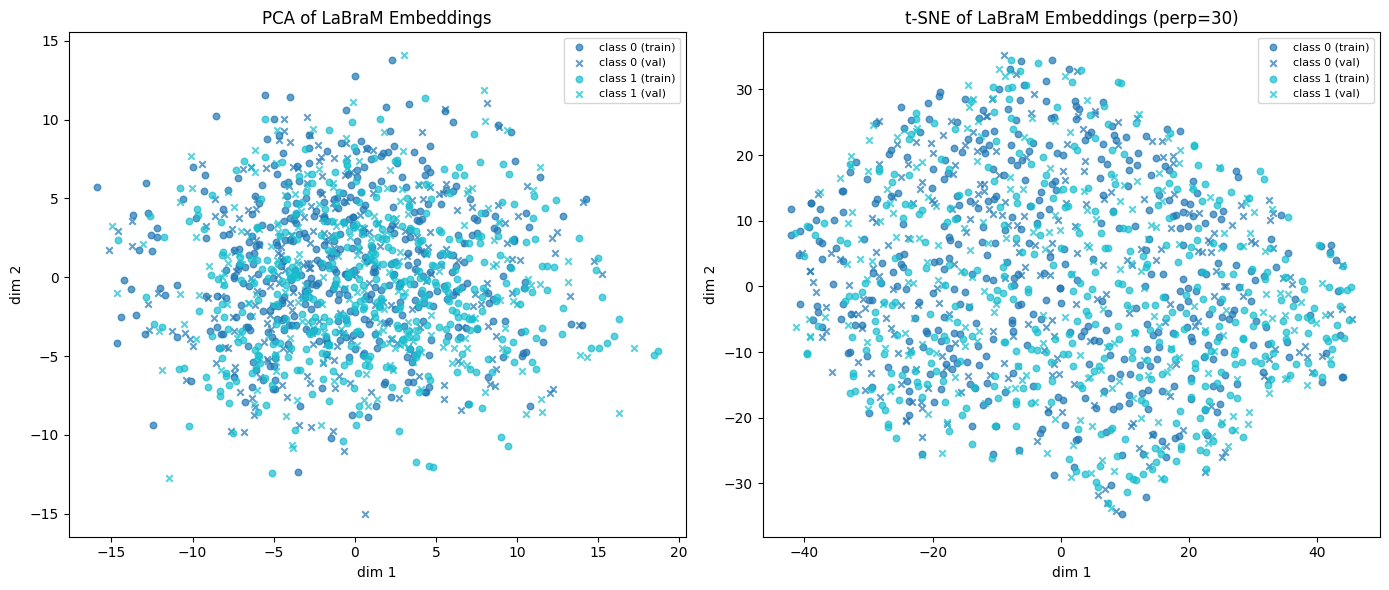

PCA explained variance ratio: [0.19062445 0.10972243]
Silhouette score (PCA 2D): 0.0099735195
Silhouette score (t-SNE 2D): 0.009950059


In [26]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

def extract_labram_embeddings(model, X_tensor, batch_size=256):
    model.eval()
    device = next(model.parameters()).device
    feats = []
    loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for (xb,) in loader:
            xb = xb.to(device)
            z = model.encode(xb, force_no_grad=True)  # shape: (B, 200)
            feats.append(z.cpu().numpy())
    return np.concatenate(feats, axis=0)

def stratified_subsample(X, y, max_per_class=400, seed=42):
    rng = np.random.default_rng(seed)
    y = np.asarray(y)
    idx = []
    for c in np.unique(y):
        c_idx = np.where(y == c)[0]
        take = min(max_per_class, len(c_idx))
        idx.extend(rng.choice(c_idx, size=take, replace=False))
    idx = np.array(idx)
    rng.shuffle(idx)
    return X[idx], y[idx]

# 1) Extract embeddings
emb_train = extract_labram_embeddings(model, X_train_t, batch_size=256)
emb_val = extract_labram_embeddings(model, X_val_t, batch_size=256)
y_train_np = y_train_t.cpu().numpy()
y_val_np = y_val_t.cpu().numpy()

# 2) Optional balanced subsample for cleaner/faster plots
emb_train_s, y_train_s = stratified_subsample(emb_train, y_train_np, max_per_class=400, seed=1)
emb_val_s, y_val_s = stratified_subsample(emb_val, y_val_np, max_per_class=400, seed=2)

X_all = np.vstack([emb_train_s, emb_val_s])
y_all = np.concatenate([y_train_s, y_val_s])
split_all = np.array(["train"] * len(emb_train_s) + ["val"] * len(emb_val_s))

# 3) Standardize features
scaler = StandardScaler()
X_all_std = scaler.fit_transform(X_all)

# 4) PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_all_std)

# 5) t-SNE
n = len(X_all_std)
perplexity = min(30, max(5, (n - 1) // 3))
tsne = TSNE(
  n_components=2,
  perplexity=perplexity,
  init="pca",
  learning_rate="auto",
  random_state=42,
)
X_tsne = tsne.fit_transform(X_all_std)

# 6) Plot helper
def plot_2d(ax, Z, y, split, title):
    classes = np.unique(y)
    colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))
    marker_map = {"train": "o", "val": "x"}
    for i, c in enumerate(classes):
        for sp in ["train", "val"]:
            mask = (y == c) & (split == sp)
            if mask.any():
                ax.scatter(
                    Z[mask, 0],
                    Z[mask, 1],
                    s=22,
                    alpha=0.7,
                    marker=marker_map[sp],
                    color=colors[i],
                    label=f"class {c} ({sp})",
                )
    ax.set_title(title)
    ax.set_xlabel("dim 1")
    ax.set_ylabel("dim 2")
    ax.legend(loc="best", fontsize=8)

# 7) Render
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_2d(axes[0], X_pca, y_all, split_all, "PCA of LaBraM Embeddings")
plot_2d(axes[1], X_tsne, y_all, split_all, f"t-SNE of LaBraM Embeddings (perp={perplexity})")
plt.tight_layout()
plt.show()

# 8) Quick numeric sanity
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
if len(np.unique(y_all)) > 1:
    print("Silhouette score (PCA 2D):", silhouette_score(X_pca, y_all))
    print("Silhouette score (t-SNE 2D):", silhouette_score(X_tsne, y_all))